# Methylation and accessibility prediction on amplicons using NN models for each base individually

21/06/03

A compilation of code from other notebooks that is used in this method, so that it can all be run together.

Before this notebook:
* Use Data_Processing.ipynb to generate scripts for pacbio processing. Run these on wynton.
* Included in the scripts is to run extractIPDfull3.py. This will generate \*full.pickle files for each sample

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from tqdm import tqdm
import pickle
import os
from Bio import Seq, SeqIO
import socket

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

if 'biochem1' in socket.gethostname():
    dataPBase = '/avicenna/vramani/analyses/pacbio/'
    figPBase = '/avicenna/cmcnally/pbanalysis/'
if 'assembler4' in socket.gethostname():
    dataPBase = '/data/users/goodarzilab/colin/results/pacbio/'
if 'wynton' in socket.gethostname():
    dataPBase = '/wynton/group/goodarzilab/ramanilab/results/pacbio/'
if 'rumi' in socket.gethostname():
    raise Exception('no pacbio results folder on rumi')
    
# load in reference sequences for both the independent and dependent CTCF sites
refFile = dataPBase + 'pbrun10_CTCFpool_2/snf2h_independent_site_observed.fasta'
for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
    if ir > 0:
        raise InputError('Reference fasta has multiple entries')
    irefseq = record.seq # reference sequence for independent CTCF site
refFile = dataPBase + 'pbrun10_CTCFpool_2/snf2h_dependent_site_observed.fasta'
for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
    if ir > 0:
        raise InputError('Reference fasta has multiple entries')
    drefseq = record.seq # reference sequence for dependent CTCF site

# Load in the sample reference tables for the CTCF site samples
sampleRef = pd.read_csv(dataPBase + 'pbrun10_CTCFpool_2/pbrun10_CTCFpool_2.sampleReference.csv')
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + 'pbrun10_CTCFpool_1/pbrun10_CTCFpool_1.sampleReference.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210516_NA_SNF2hCTCFarray_ST_rep2/210516_NA_SNF2hCTCFarray_ST_rep2.sampleReference.wynton.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210520_NA_SNF2hCTCFarray_MT_rep1/210520_NA_SNF2hCTCFarray_MT_rep1.sampleReference.wynton.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210608_NA_SNF2hCTCFarray_MT_rep2/210608_NA_SNF2hCTCFarray_MT_rep2.sampleReference.wynton.csv')],
                      ignore_index=True)

del sampleRef['index']

indepSamples = np.nonzero([(name[0:5] == 'Indep' or name[0:8] == 'CTCF_Ind') for name in sampleRef['sampleName']])[0]
depSamples = np.nonzero([(name[0:5] == 'Depen' or name[0:8] == 'CTCF_Dep') for name in sampleRef['sampleName']])[0]

In [9]:
pd.set_option('display.max_rows', 100)
sampleRef

cell                       sampleName  \
0                 pbrun10_CTCFpool_2                Indep_naked_plusM   
1                 pbrun10_CTCFpool_2               Indep_naked_minusM   
2                 pbrun10_CTCFpool_2                Depen_naked_plusM   
3                 pbrun10_CTCFpool_2               Depen_naked_minusM   
4                 pbrun10_CTCFpool_2           IndepArray_20to1_plusM   
5                 pbrun10_CTCFpool_2           IndepArray_15to1_plusM   
6                 pbrun10_CTCFpool_2           IndepArray_10to1_plusM   
7                 pbrun10_CTCFpool_2            IndepArray_5to1_plusM   
8                 pbrun10_CTCFpool_2           DepenArray_20to1_plusM   
9                 pbrun10_CTCFpool_2           DepenArray_15to1_plusM   
10                pbrun10_CTCFpool_2           DepenArray_10to1_plusM   
11                pbrun10_CTCFpool_2            DepenArray_5to1_plusM   
12                pbrun10_CTCFpool_2         IndepArray_20to1_plusATP   
13                pbrun10_CTCFpool_2         IndepArray_15to1_plusATP   
14                pbrun10_CTCFpool_2         IndepArray_10to1_plusATP   
15                pbrun10_CTCFpool_2          IndepArray_5to1_plusATP   
16                pbrun10_CTCFpool_2         DepenArray_20to1_plusADP   
17                pbrun10_CTCFpool_2         DepenArray_15to1_plusADP   
18                pbrun10_CTCFpool_2         DepenArray_10to1_plusADP   
19                pbrun10_CTCFpool_2          DepenArray_5to1_plusADP   
20                pbrun10_CTCFpool_1  DepenArray_20to1_plusM_minusATP   
21                pbrun10_CTCFpool_1  DepenArray_15to1_plusM_minusATP   
22                pbrun10_CTCFpool_1  DepenArray_10to1_plusM_minusATP   
23                pbrun10_CTCFpool_1   DepenArray_5to1_plusM_minusATP   
24                pbrun10_CTCFpool_1  IndepArray_20to1_plusM_minusATP   
25                pbrun10_CTCFpool_1  IndepArray_15to1_plusM_minusATP   
26                pbrun10_CTCFpool_1  IndepArray_10to1_plusM_minusATP   
27                pbrun10_CTCFpool_1   IndepArray_5to1_plusM_minusATP   
28                pbrun10_CTCFpool_1         DepenArray_20to1_plusATP   
29                pbrun10_CTCFpool_1         DepenArray_15to1_plusATP   
30                pbrun10_CTCFpool_1         DepenArray_10to1_plusATP   
31                pbrun10_CTCFpool_1          DepenArray_5to1_plusATP   
32                pbrun10_CTCFpool_1         IndepArray_20to1_plusADP   
33                pbrun10_CTCFpool_1         IndepArray_15to1_plusADP   
34                pbrun10_CTCFpool_1         IndepArray_10to1_plusADP   
35                pbrun10_CTCFpool_1          IndepArray_5to1_plusADP   
36  210516_NA_SNF2hCTCFarray_ST_rep2        CTCF_Dep_20to1_plusATP_ST   
37  210516_NA_SNF2hCTCFarray_ST_rep2        CTCF_Dep_15to1_plusATP_ST   
38  210516_NA_SNF2hCTCFarray_ST_rep2        CTCF_Dep_10to1_plusATP_ST   
39  210516_NA_SNF2hCTCFarray_ST_rep2         CTCF_Dep_5to1_plusATP_ST   
40  210516_NA_SNF2hCTCFarray_ST_rep2        CTCF_Ind_20to1_plusATP_ST   
41  210516_NA_SNF2hCTCFarray_ST_rep2        CTCF_Ind_15to1_plusATP_ST   
42  210516_NA_SNF2hCTCFarray_ST_rep2        CTCF_Ind_10to1_plusATP_ST   
43  210516_NA_SNF2hCTCFarray_ST_rep2         CTCF_Ind_5to1_plusATP_ST   
44  210516_NA_SNF2hCTCFarray_ST_rep2        CTCF_Dep_20to1_plusADP_ST   
45  210516_NA_SNF2hCTCFarray_ST_rep2        CTCF_Dep_15to1_plusADP_ST   
46  210516_NA_SNF2hCTCFarray_ST_rep2        CTCF_Dep_10to1_plusADP_ST   
47  210516_NA_SNF2hCTCFarray_ST_rep2         CTCF_Dep_5to1_plusADP_ST   
48  210516_NA_SNF2hCTCFarray_ST_rep2        CTCF_Ind_20to1_plusADP_ST   
49  210516_NA_SNF2hCTCFarray_ST_rep2        CTCF_Ind_15to1_plusADP_ST   
50  210516_NA_SNF2hCTCFarray_ST_rep2        CTCF_Ind_10to1_plusADP_ST   
51  210516_NA_SNF2hCTCFarray_ST_rep2         CTCF_Ind_5to1_plusADP_ST   
52  210520_NA_SNF2hCTCFarray_MT_rep1   CTCF_Dep_20to1_plusATP_MT_rep1   
53  210520_NA_SNF2hCTCFarray_MT_rep1   CTCF_Dep_15to1_plusATP_MT_rep1   
54  210520_NA_SNF

In [4]:
# short temporary, delete later
# 21/08/04
# Just wanted to run this code from NN_SingleA while that notebook was busy running a different cell

sampleRef = pd.read_csv(dataPBase + 'sampleRef_K562_mESC.csv', sep=',', index_col=0)

from glob import glob

with open('/data/users/goodarzilab/colin/code/scripts/doHMM.sh', 'w') as fout:
    for samp in [33, 31, 34]: #the three samples that still need to be done as of late on 8/4
        pieces = glob(os.path.join(dataPBase,sampleRef['cell'][samp],'processed','forHMM',
                              sampleRef['cell'][samp] + '_' + 
                              sampleRef['sampleName'][samp] + '_forHMM_piece*.pickle'))
        ipiece = 0
        for p in pieces:
            fout.write('qsub /wynton/home/goodarzi/cpmcnally/code/scripts/shellRunAccessibilityHMM.sh {0} {1}\n'.format(samp,
                                                                                                                        ipiece))
            ipiece += 1

In [4]:
# Alternatively, for Widom molecules

amplicon = 'widom'
sampleRef =  pd.read_csv(dataPBase + 'pbrun3-9_SampleReference.csv')

samp = 44
for ir, record in enumerate(SeqIO.parse(sampleRef['reference'][samp], 'fasta')):
    if ir > 0:
        raise InputError('Reference fasta has multiple entries')
    wrefseq = record.seq

In [5]:
len(wrefseq)

2268

In [6]:
#pd.read_csv('/avicenna/vramani/analyses/pacbio/210516_NA_SNF2hCTCFarray_ST_rep2/210516_NA_SNF2hCTCFarray_ST_rep2.sampleReference.wynton.csv')

In [10]:
def latentifyMakeNNinput(cellname, sampname, refseq, svdmodel=None):
    with open(os.path.join(dataPBase, cellname,'processed','full', 
                       cellname + '_' + sampname + '_full.pickle'), 'rb') as fin:
        ipds = pickle.load(fin, encoding="latin1")
    
    refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T']}
    
    notaFor = np.logical_or.reduce([refis['A'],refis['C'],refis['G']])
    notaRev = np.logical_or.reduce([refis['T'],refis['C'],refis['G']])
    nfor = np.sum(notaFor)
    nrev = np.sum(notaRev)

    notaipd = np.full((len(ipds), (nfor + nrev)), np.nan, dtype=np.float32)

    for i in range(len(ipds)):
        notaipd[i, 0:nfor] = ipds[i]['fmean'][notaFor]
        notaipd[i, nfor:(nfor+nrev)] = ipds[i]['rmean'][notaRev]
        
    notaipd = notaipd - np.nanmean(notaipd, axis=0)
    indices = np.nonzero(~np.isnan(notaipd))
    sparsem = coo_matrix( (notaipd[indices], indices), shape=notaipd.shape)
    sparsem = csr_matrix(sparsem)
    
    if svdmodel is None:
        svdmodel = TruncatedSVD(n_components=40, n_iter=20, random_state=33)
        svdmodel.fit(sparsem)
        pcvars = svdmodel.transform(sparsem)
    else:
        pcvars = svdmodel.transform(sparsem)
        
    stpcvars = pcvars - pcvars.mean(axis=0)
    stpcvars = stpcvars / stpcvars.std(axis=0)
    
    onlyATref = [b for b in refseq if b == 'A' or b == 'T']
    refisonly = {n: np.array([b is n for b in onlyATref]) for n in ['A','T']}

    aipd = np.full((len(ipds), len(onlyATref)), np.nan, dtype=np.float32)
    for i in range(len(ipds)):
        aipd[i, refisonly['T']] = ipds[i]['fmean'][refis['T']]
        aipd[i, refisonly['A']] = ipds[i]['rmean'][refis['A']]
    
    abaseInd = np.nonzero(np.logical_or(refis['A'], refis['T']))[0]
    if not os.path.exists(dataPBase + '%s/processed/forNN' % (cellname)):
        os.makedirs(dataPBase + '%s/processed/forNN' % (cellname))
    # write nn input file
    np.savez(os.path.join(dataPBase, cellname,'processed','forNN',
                           cellname + '_' + sampname + '_forNNsimple.npz'), 
             aipd = aipd,
             stpcvars = stpcvars, 
             abaseInd = abaseInd)
        
    return svdmodel

In [10]:
# independent site samples

samp = 1 # the independent site naked unmethylated control
isvdmod = latentifyMakeNNinput(sampleRef['cell'][samp], sampleRef['sampleName'][samp], irefseq)

for samp in tqdm(indepSamples):
    isvdmod = latentifyMakeNNinput(sampleRef['cell'][samp], sampleRef['sampleName'][samp], irefseq, isvdmod)
    
# dependent site samples

samp = 3 # the dependent site naked unmethylated control
dsvdmod = latentifyMakeNNinput(sampleRef['cell'][samp], sampleRef['sampleName'][samp], drefseq)

for samp in tqdm(depSamples):
    dsvdmod = latentifyMakeNNinput(sampleRef['cell'][samp], sampleRef['sampleName'][samp], drefseq, dsvdmod)
    
svdModelD = {}
svdModelD['independent'] = isvdmod
svdModelD['dependent'] = dsvdmod

with open('/data/users/goodarzilab/colin/models/CTCFsites/svdModels.pickle', 'wb') as fout:
    pickle.dump(svdModelD, fout)

100%|██████████| 34/34 [05:05<00:00,  8.99s/it]


In [15]:
with open('/data/users/goodarzilab/colin/models/CTCFsites/svdModels.pickle', 'rb') as fin:
    svdModelD = pickle.load(fin)
    
redoInd = indepSamples[indepSamples >= 72]
redoDep = depSamples[depSamples >= 72]

for samp in tqdm(redoInd, position=0):
    isvdmod = latentifyMakeNNinput(sampleRef['cell'][samp], sampleRef['sampleName'][samp], irefseq, svdModelD['independent'])
    
for samp in tqdm(redoDep, position=0):
    dsvdmod = latentifyMakeNNinput(sampleRef['cell'][samp], sampleRef['sampleName'][samp], drefseq, svdModelD['dependent'])

100%|██████████| 12/12 [02:04<00:00, 10.37s/it]


array([72, 73, 74, 75, 80, 81, 82, 83, 88, 89, 90, 91])

In [2]:
# now use NN to get residuals
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

def getResiduals(samp, models=None, nAdenine=None, suffix=''):

    with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','forNN',
                              sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_forNNsimple.npz')) as data:
        aipd = data['aipd']
        pcvars = data['stpcvars']

    resids = np.full(aipd.shape, np.nan, dtype=np.float32)

    fitmodels = False
    if models is None:
        fitmodels = True
        models = {}
        
        optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
            
        pcv_input = keras.layers.Input(shape=pcvars.shape[1:])
        lay1 = keras.layers.Dense(200, activation="relu", kernel_initializer='he_uniform')(pcv_input)
        lay2 = keras.layers.Dense(200, activation="relu", kernel_initializer='he_uniform')(lay1)
        lay3 = keras.layers.Dense(200, activation="relu", kernel_initializer='he_uniform')(lay2)
        outputs = keras.layers.Dense(1)(lay3)
        basemodel = keras.models.Model(inputs=[pcv_input],
                                       outputs=[outputs])
    
    if nAdenine is not None:
        useA = range(min(nAdenine, aipd.shape[1]))
    else:
        useA = range(aipd.shape[1])
    
    for base in tqdm(useA, position=0, desc=sampleRef['sampleName'][samp], smoothing=0.001):
        mol = np.nonzero(~np.isnan(aipd[:,base]))[0]
        
        if fitmodels:
            models[base] = tf.keras.models.clone_model(basemodel)
            models[base].compile(loss="mean_squared_error", optimizer=optimizer)
        
            history = models[base].fit([pcvars[mol,:]], aipd[mol, base], epochs=20, batch_size=256, shuffle=True, verbose=0)

        pred = models[base].predict(pcvars[mol,:], batch_size=4096)
        resid = aipd[mol,base].flatten() - pred.flatten()

        resids[mol,base] = resid
        
    if not os.path.exists(dataPBase + '%s/processed/NNres' % (sampleRef['cell'][samp])):
        os.makedirs(dataPBase + '%s/processed/NNres' % (sampleRef['cell'][samp]))
        
    np.savez(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','NNres',
                           sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_residuals'
                          + suffix + '.npz'),
             residuals = resids)
    
    return models


In [4]:
samp = 1

with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','forNN',
                              sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_forNNsimple.npz')) as data:
    aipd = data['aipd']
    pcvars = data['stpcvars']

In [51]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
            
pcv_input = keras.layers.Input(shape=pcvars.shape[1:])
lay1 = keras.layers.Dense(200, activation="relu", kernel_initializer='he_uniform')(pcv_input)
lay2 = keras.layers.Dense(200, activation="relu", kernel_initializer='he_uniform')(lay1)
lay3 = keras.layers.Dense(200, activation="relu", kernel_initializer='he_uniform')(lay2)
outputs = keras.layers.Dense(1)(lay3)
model = keras.models.Model(inputs=[pcv_input],
                               outputs=[outputs])
model.compile(loss="mean_squared_error", optimizer="Adam")
base = 50
mol = np.nonzero(~np.isnan(aipd[:,base]))[0]
trainmol = mol[0:25000]
validmol = mol[25000:]
history = model.fit([pcvars[trainmol,:]], aipd[trainmol,base],
                    epochs=12, batch_size=32, shuffle=True,
                    validation_data=([pcvars[validmol,:]], aipd[validmol,base]))

Epoch 1/12
782/782 [==============================] - 3s 3ms/step - loss: 0.2554 - val_loss: 0.0467
Epoch 2/12
782/782 [==============================] - 3s 3ms/step - loss: 0.1131 - val_loss: 0.0311
Epoch 3/12
782/782 [==============================] - 3s 3ms/step - loss: 0.0288 - val_loss: 0.0292
Epoch 4/12
782/782 [==============================] - 3s 3ms/step - loss: 0.0248 - val_loss: 0.0281
Epoch 5/12
782/782 [==============================] - 3s 3ms/step - loss: 0.0277 - val_loss: 0.0260
Epoch 6/12
782/782 [==============================] - 3s 3ms/step - loss: 0.0491 - val_loss: 0.0250
Epoch 7/12
782/782 [==============================] - 3s 3ms/step - loss: 0.0226 - val_loss: 0.0256
Epoch 8/12
782/782 [==============================] - 3s 3ms/step - loss: 0.0299 - val_loss: 0.0245
Epoch 9/12
782/782 [==============================] - 3s 3ms/step - loss: 0.0202 - val_loss: 0.0257
Epoch 10/12
782/782 [==============================] - 3s 3ms/step - loss: 0.0429 - val_loss: 0.0257

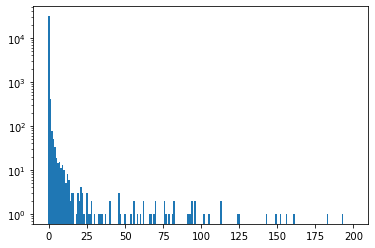

In [35]:
a = np.sum(np.isnan(aipd), axis=1)

plt.hist(a, np.arange(-0.5, 200.5))
plt.yscale('log')


In [24]:
np.sum(np.sum(np.isnan(aipd), axis=1) == 0)

31159

In [54]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
            
pcv_input = keras.layers.Input(shape=pcvars.shape[1:])
lay1 = keras.layers.Dense(400, activation="relu", kernel_initializer='he_uniform')(pcv_input)
drop1 = keras.layers.Dropout(0.5)(lay1)
lay2 = keras.layers.Dense(400, activation="relu", kernel_initializer='he_uniform')(drop1)
drop2 = keras.layers.Dropout(0.5)(lay2)
lay3 = keras.layers.Dense(400, activation="relu", kernel_initializer='he_uniform')(drop2)
drop3 = keras.layers.Dropout(0.5)(lay3)
lay4 = keras.layers.Dense(400, activation="relu", kernel_initializer='he_uniform')(drop3)
drop4 = keras.layers.Dropout(0.5)(lay4)
outputs = keras.layers.Dense(aipd.shape[1])(drop4)
model = keras.models.Model(inputs=[pcv_input],
                               outputs=[outputs])
model.compile(loss="mean_squared_error", optimizer="Adam")


mol = np.nonzero(np.sum(np.isnan(aipd), axis=1) == 0)[0]
print(mol.shape)
trainmol = mol[0:25000]
validmol = mol[25000:]
history = model.fit([pcvars[trainmol,:]], aipd[trainmol,:],
                    epochs=100, batch_size=128, shuffle=True,
                    validation_data=([pcvars[validmol,:]], aipd[validmol,:]))

(31159,)
Epoch 1/100
196/196 [==============================] - 1s 5ms/step - loss: 0.9318 - val_loss: 0.3800
Epoch 2/100
196/196 [==============================] - 1s 5ms/step - loss: 0.1354 - val_loss: 0.0707
Epoch 3/100
196/196 [==============================] - 1s 5ms/step - loss: 0.0639 - val_loss: 0.0511
Epoch 4/100
196/196 [==============================] - 1s 5ms/step - loss: 0.0517 - val_loss: 0.0472
Epoch 5/100
196/196 [==============================] - 1s 5ms/step - loss: 0.0459 - val_loss: 0.0432
Epoch 6/100
196/196 [==============================] - 1s 5ms/step - loss: 0.0402 - val_loss: 0.0382
Epoch 7/100
196/196 [==============================] - 1s 5ms/step - loss: 0.0366 - val_loss: 0.0377
Epoch 8/100
196/196 [==============================] - 1s 5ms/step - loss: 0.0357 - val_loss: 0.0342
Epoch 9/100
196/196 [==============================] - 1s 5ms/step - loss: 0.0332 - val_loss: 0.0308
Epoch 10/100
196/196 [==============================] - 1s 5ms/step - loss: 0.0330

In [40]:
pred = model.predict(pcvars, batch_size=4096)



In [43]:
resid = aipd - pred

In [17]:
############ Alternate model that predicts all bases at once

# now use NN to get residuals
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

def getResiduals(samp, model=None, suffix=''):

    with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','forNN',
                              sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_forNNsimple.npz')) as data:
        aipd = data['aipd']
        pcvars = data['stpcvars']

    if model is None:
                    
        pcv_input = keras.layers.Input(shape=pcvars.shape[1:])
        lay1 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(pcv_input)
        drop1 = keras.layers.Dropout(0.5)(lay1)
        lay2 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(drop1)
        drop2 = keras.layers.Dropout(0.5)(lay2)
        lay3 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(drop2)
        drop3 = keras.layers.Dropout(0.5)(lay3)
        lay4 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(drop3)
        drop4 = keras.layers.Dropout(0.5)(lay4)
        outputs = keras.layers.Dense(aipd.shape[1])(drop4)
        model = keras.models.Model(inputs=[pcv_input],
                                       outputs=[outputs])
        model.compile(loss="mean_squared_error", optimizer="Adam")
    
        mol = np.nonzero(np.sum(np.isnan(aipd), axis=1) == 0)[0]
        
        
        history = model.fit([pcvars[mol,:]], aipd[mol, :],
                            epochs=100, batch_size=128, shuffle=True, verbose=0)

    pred = model.predict(pcvars, batch_size=512)
    resid = aipd - pred
        
    if not os.path.exists(dataPBase + '%s/processed/NNres' % (sampleRef['cell'][samp])):
        os.makedirs(dataPBase + '%s/processed/NNres' % (sampleRef['cell'][samp]))
        
    np.savez(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','NNres',
                           sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_residuals'
                          + suffix + '.npz'),
             residuals = resid)
    
    return model


In [6]:
# widom
amplicon = 'widom'
useSamples = {'indep':indepSamples, 'dep':depSamples, 'widom':[3, 44, 45, 47, 48, 51, 52]}

samp = 44
imodel = getResiduals(samp)

for samp in tqdm(useSamples[amplicon]):
    if samp == 44:
        continue
    imodel = getResiduals(samp, imodel)
    
if not os.path.exists(dataPBase + 'pbrun6/processed/NNmodels'):
        os.makedirs(dataPBase + 'pbrun6/processed/NNmodels')
        
imodel.save(dataPBase + 'pbrun6/processed/NNmodels/NNresid_widom_model')

100%|██████████| 7/7 [00:22<00:00,  3.21s/it]


In [7]:
samp = 1
imodel = getResiduals(samp)
    
for samp in tqdm(indepSamples):
    if samp == 1:
        continue
    imodel = getResiduals(samp, imodel)
    
if not os.path.exists(dataPBase + 'pbrun10_CTCFpool_2/processed/NNmodels'):
        os.makedirs(dataPBase + 'pbrun10_CTCFpool_2/processed/NNmodels')
        
imodel.save(dataPBase + 'pbrun10_CTCFpool_2/processed/NNmodels/NNresid_indep_model')
    
# not dependent site samples
samp = 3
dmodel = getResiduals(samp)
    
for samp in tqdm(depSamples):
    if samp == 3:
        continue
    dmodel = getResiduals(samp, dmodel)
        
dmodel.save(dataPBase + 'pbrun10_CTCFpool_2/processed/NNmodels/NNresid_dep_model')


100%|██████████| 34/34 [00:36<00:00,  1.08s/it]


In [19]:
imodel = keras.models.load_model(dataPBase + 'pbrun10_CTCFpool_2/processed/NNmodels/NNresid_indep_model')
dmodel = keras.models.load_model(dataPBase + 'pbrun10_CTCFpool_2/processed/NNmodels/NNresid_dep_model')

redoInd = indepSamples[indepSamples >= 72]
redoDep = depSamples[depSamples >= 72]

for samp in tqdm(redoInd, position=0):
    imodel = getResiduals(samp, imodel)

for samp in tqdm(redoDep, position=0):
    dmodel = getResiduals(samp, dmodel)

100%|██████████| 12/12 [00:15<00:00,  1.27s/it]


## Mixture model classification

In [38]:
# Now load in NN residuals and apply GMM

from sklearn.mixture import GaussianMixture
from scipy.stats import norm


refs = {'indep':irefseq, 'dep':drefseq} #, 'widom':wrefseq}
posControl = {'indep':0, 'dep':2, 'widom':45}
negControl = {'indep':1, 'dep':3, 'widom':44}


amplicon = 'dep'

refseq = refs[amplicon]
refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T']}
abaseInd = np.nonzero(np.logical_or(refis['A'], refis['T']))[0]

residuals = []
sampleOr = []

for samp in [posControl[amplicon],negControl[amplicon]]:
    with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','NNres',
                               sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_residuals.npz')) as data:
        residuals.append(data['residuals'])
        sampleOr.append(np.full((data['residuals'].shape[0],1), samp))

In [36]:
np.append([0,1], redoInd)

array([ 0,  1, 76, 77, 78, 79, 84, 85, 86, 87])

Text(0, 0.5, 'Median residual')

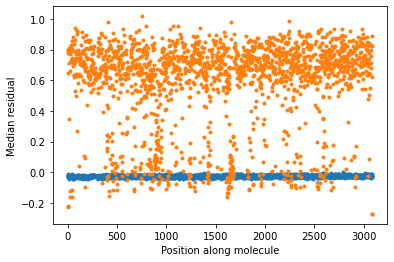

In [55]:
negmed = []
posmed = []

for base in range(residuals[0].shape[1]):
    posmed.append(np.nanmedian(residuals[0][:,base]))
    negmed.append(np.nanmedian(residuals[1][:,base]))
posmed = np.array(posmed)
negmed = np.array(negmed)

plt.plot(abaseInd, negmed, '.')
plt.plot(abaseInd, posmed, '.')
plt.xlabel('Position along molecule')
plt.ylabel('Median residual')

In [10]:
minmol

1762

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

minmol = min(residuals[0].shape[0], residuals[1].shape[0])
usemol0 = np.random.choice(np.arange(residuals[0].shape[0]), size=minmol, replace=False)
usemol1 = np.random.choice(np.arange(residuals[1].shape[0]), size=minmol, replace=False)
concdat = np.concatenate([residuals[0][usemol0,:], residuals[1][usemol1,:]])

gmmfd = {'basei':[], 'threshold':[], 'meanlow':[], 'meanhigh':[], 'weighthigh':[], 'lowcut':[],
         'lowprob':[], 'aicd':[], 'cutoff':[], 'converged':[]}

gmmFitd = {}

for b in tqdm(range(residuals[0].shape[1]), position=0, smoothing=0):
    
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        gmm1 = GaussianMixture(1, covariance_type='spherical')
        gmm1.fit(usedat)
        gmm2 = GaussianMixture(2, covariance_type='spherical', tol=1e-4, means_init=np.array([0,0.75]).reshape(2,1))
        gmm2.fit(usedat)
        if not gmm2.converged_:
            gmmfd['converged'].append(False)
        else:
            gmmfd['converged'].append(True)
    gmmFitd[b] = gmm2
    
    xfine = np.linspace(0,1,1001)
    preda = gmm2.predict_proba(xfine.reshape(-1,1))
    cutoff = xfine[np.abs(preda[:,1] - 0.5).argmin()]
    lowcut = preda[0,1] #xfine[np.abs(preda[:,1] - 0.01).argmin()]
    
    gmmfd['basei'].append(b)
    gmmfd['threshold'].append(cutoff)
    gmmfd['meanlow'].append(gmm2.means_[0][0])
    gmmfd['meanhigh'].append(gmm2.means_[1][0])
    gmmfd['weighthigh'].append(gmm2.weights_[1])
    gmmfd['lowcut'].append(lowcut)
    gmmfd['lowprob'].append(gmm2.predict_proba(np.array([-0.4]).reshape(-1,1))[0,1])
    gmmfd['aicd'].append(gmm1.aic(usedat) - gmm2.aic(usedat))
    gmmfd['cutoff'].append(cutoff)
    
gmmfd = pd.DataFrame(gmmfd)

In [63]:
if amplicon == 'indep':
    passfilt = np.logical_and.reduce([gmmfd['meanhigh'] > 0.5,
                                      gmmfd['weighthigh'] > 0.1,
                                      gmmfd['aicd'] > 500,
                                      gmmfd['lowprob'] < 0.03,
                                      gmmfd['converged'] == True])

if amplicon == 'dep':
    passfilt = np.logical_and.reduce([gmmfd['meanhigh'] > 0.4,
                                      gmmfd['weighthigh'] > 0.1,
                                      gmmfd['aicd'] > 400,
                                      gmmfd['lowprob'] < 0.03,
                                      gmmfd['converged'] == True])
    
goodbase = np.nonzero(passfilt)[0]
badbase = np.nonzero(~passfilt)[0]
    
print(len(goodbase))
print(len(badbase))

1455
307


In [53]:
# now apply threshhold to all samples
useSamples = {'indep':indepSamples, 'dep':depSamples, 'widom':[3, 44, 45, 47, 48, 51, 52]}
for samp in tqdm(useSamples[amplicon], position=0):
    with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','NNres',
                               sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_residuals.npz')) as data:
        resid = data['residuals']
        
    methbin = np.full(resid.shape, np.nan, dtype=np.float32)
    
    for b in range(methbin.shape[1]):
        if b in goodbase:
            hasmeasure = ~np.isnan(resid[:,b])
            methbin[hasmeasure,b] = resid[hasmeasure,b] > gmmfd['threshold'][b]
            
    if not os.path.exists(dataPBase + '%s/processed/binarized' % (sampleRef['cell'][samp])):
        os.makedirs(dataPBase + '%s/processed/binarized' % (sampleRef['cell'][samp]))
        
    np.savez(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','binarized',
                               sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_binarized.npz'),
             methpred = methbin)

100%|██████████| 38/38 [01:17<00:00,  2.03s/it]


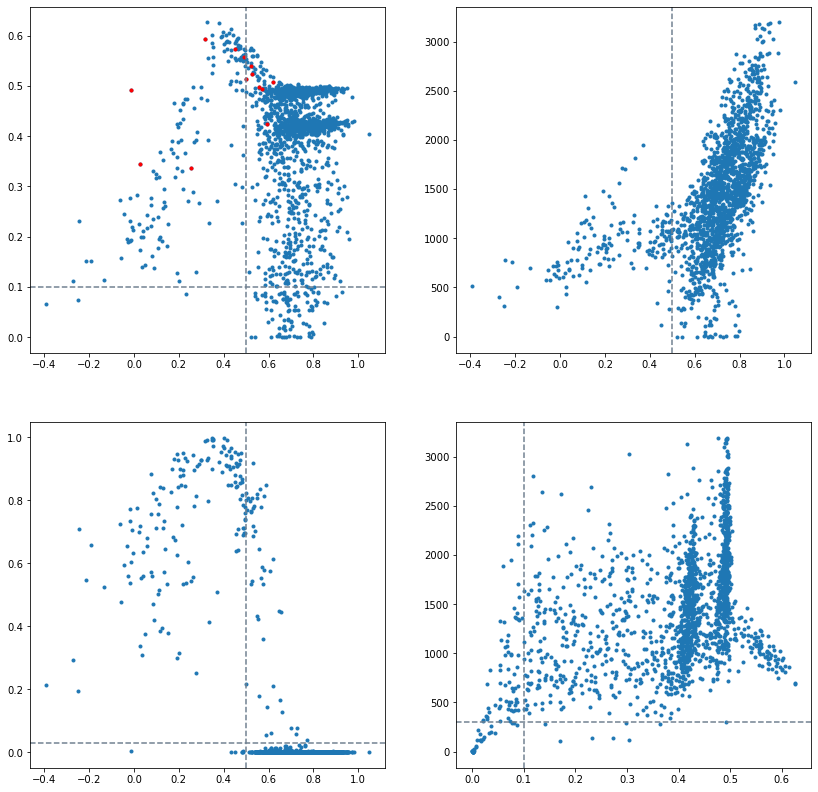

In [57]:
fig, ax = plt.subplots(2,2, figsize=(14,14))
ax[0,0].plot(gmmfd['meanhigh'], gmmfd['weighthigh'], '.')
ax[0,0].plot(gmmfd['meanhigh'][gmmfd['converged'] == False], gmmfd['weighthigh'][gmmfd['converged'] == False], '.r')
ax[0,0].axvline(x=0.5, ls='--', color='slategray')
ax[0,0].axhline(y=0.1, ls='--', color='slategray')

ax[0,1].plot(gmmfd['meanhigh'], gmmfd['aicd'], '.')
ax[0,1].axvline(x=0.5, ls='--', color='slategray')

ax[1,0].plot(gmmfd['meanhigh'], gmmfd['lowprob'], '.')
ax[1,0].axvline(x=0.5, ls='--', color='slategray')
ax[1,0].axhline(y=0.03, ls='--', color='slategray')


ax[1,1].plot(gmmfd['weighthigh'], gmmfd['aicd'], '.')
ax[1,1].axvline(x=0.1, ls='--', color='slategray')
ax[1,1].axhline(y=300, ls='--', color='slategray')

100%|██████████| 100/100 [00:08<00:00, 11.37it/s]


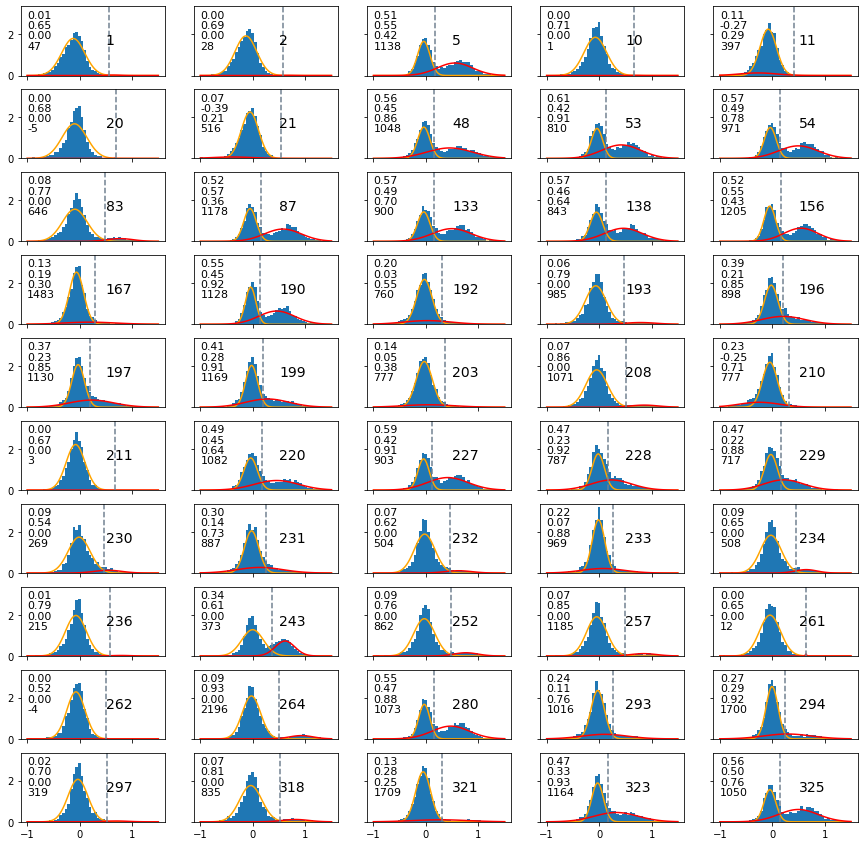

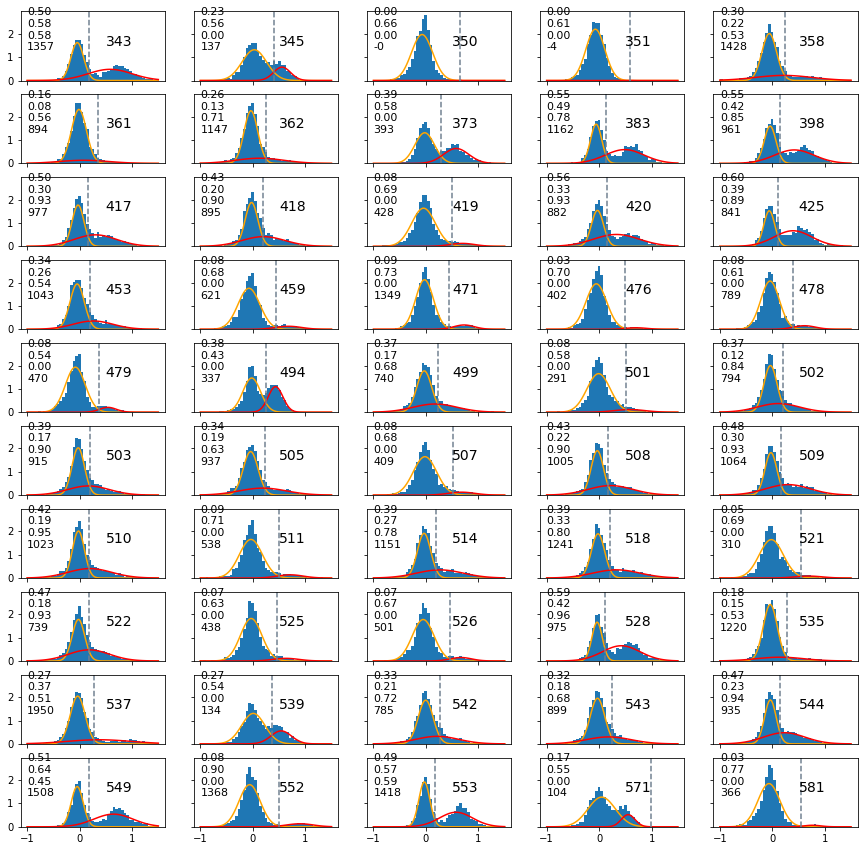

In [64]:
figw = 5
figh = 10
figind = 50

x=np.linspace(-1,1.5,100)

for b in tqdm(badbase[0:100], position=0):
    
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    
    if figind >= (figw * figh):
        fig, ax = plt.subplots(figh, figw, figsize=(15, 15), sharex=True, sharey=True)
        figind = 0
        
    ax[int(figind / figw), figind % figw].hist(usedat, np.linspace(-1, 1.5, 50), density=True)
    for comp, col in [(0,'orange'), (1,'red')]:
        ax[int(figind / figw), figind % figw].plot(x, gmmFitd[b].weights_[comp]*norm.pdf(x, loc=gmmFitd[b].means_[comp][0], scale=np.sqrt(gmmFitd[b].covariances_[comp])), color=col)
    #ax[int(figind / figw), figind % figw].axvline(x=cutoff, ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].axvline(x=gmmfd['cutoff'][b], ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].text(.5,1.5, b, fontsize=14)
    ax[int(figind / figw), figind % figw].text(-1,2.8, '{:.2f}'.format(gmmfd['weighthigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,2.3, '{:.2f}'.format(gmmfd['meanhigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.8, '{:.2f}'.format(gmmfd['lowprob'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.3, '{:.0f}'.format(gmmfd['aicd'][b]), fontsize=11)
    figind += 1
    #plt.xlabel('residual')

100%|██████████| 500/500 [00:30<00:00, 16.55it/s]


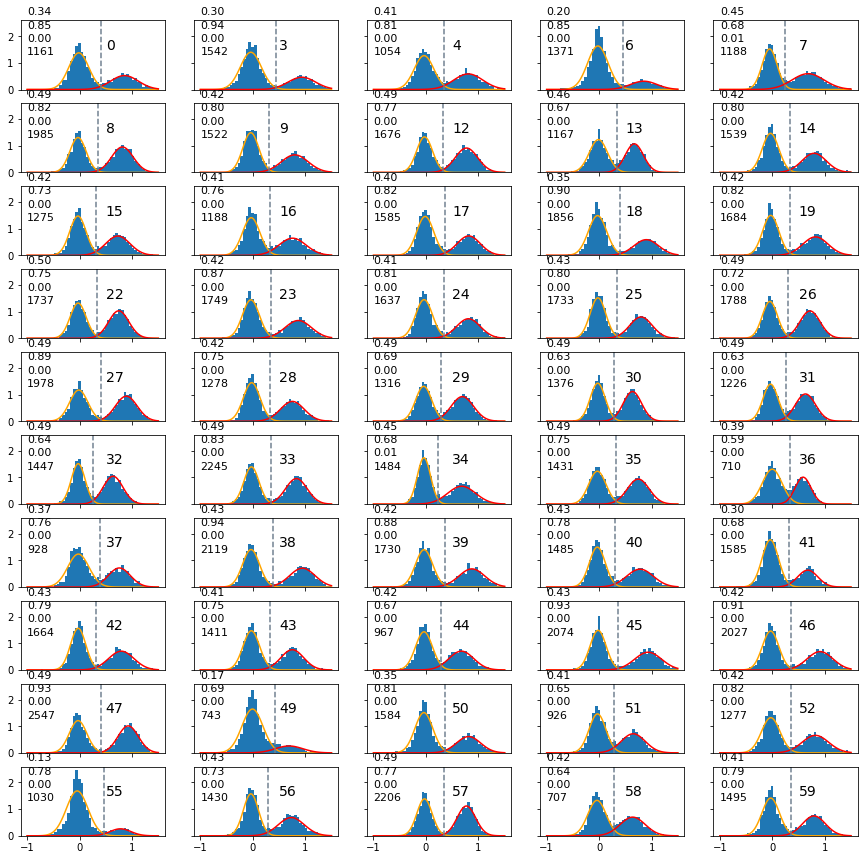

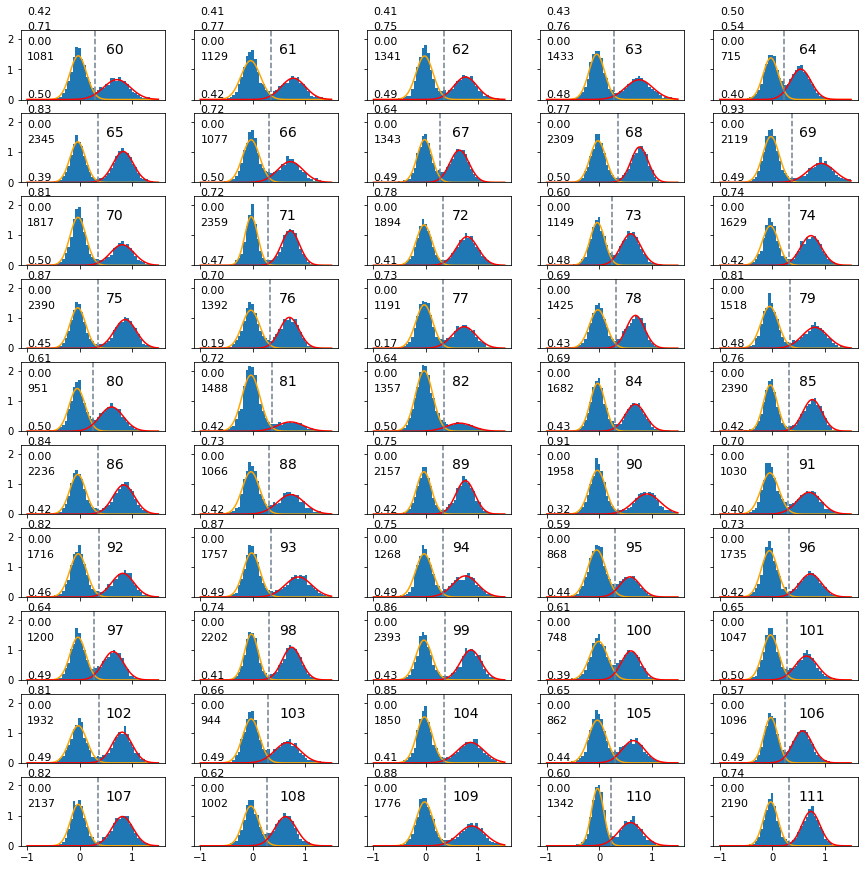

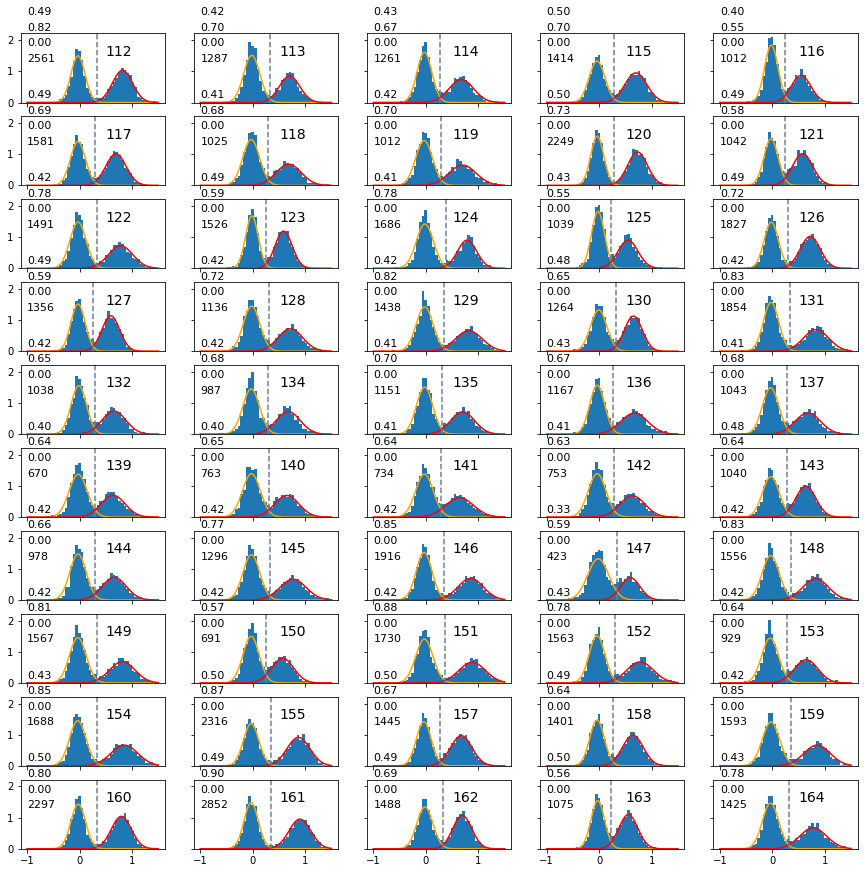

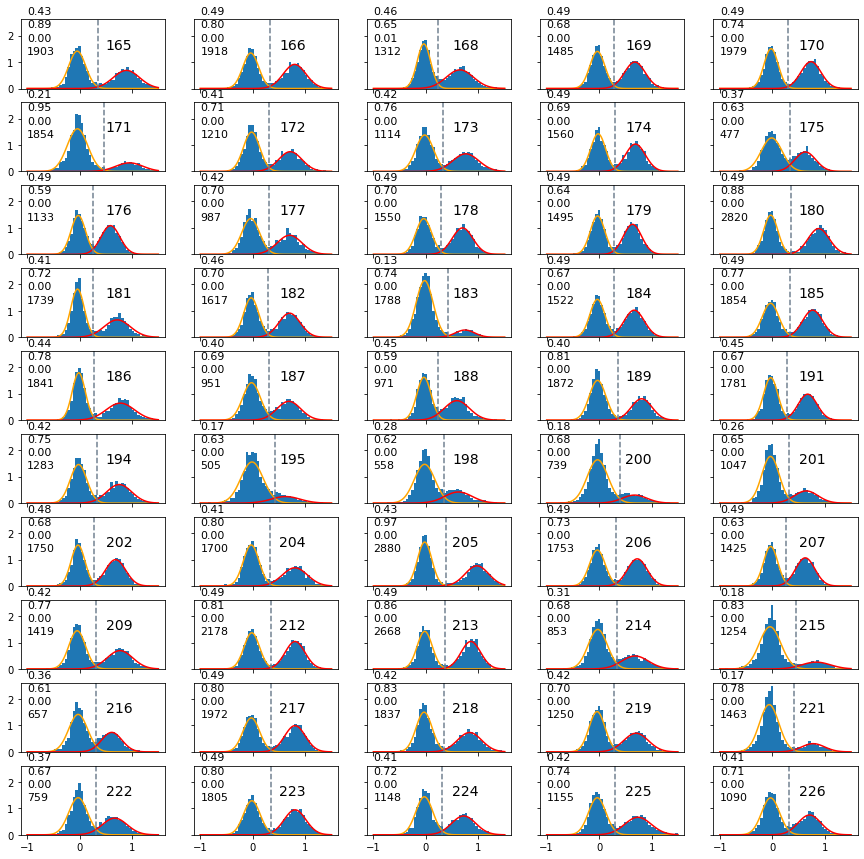

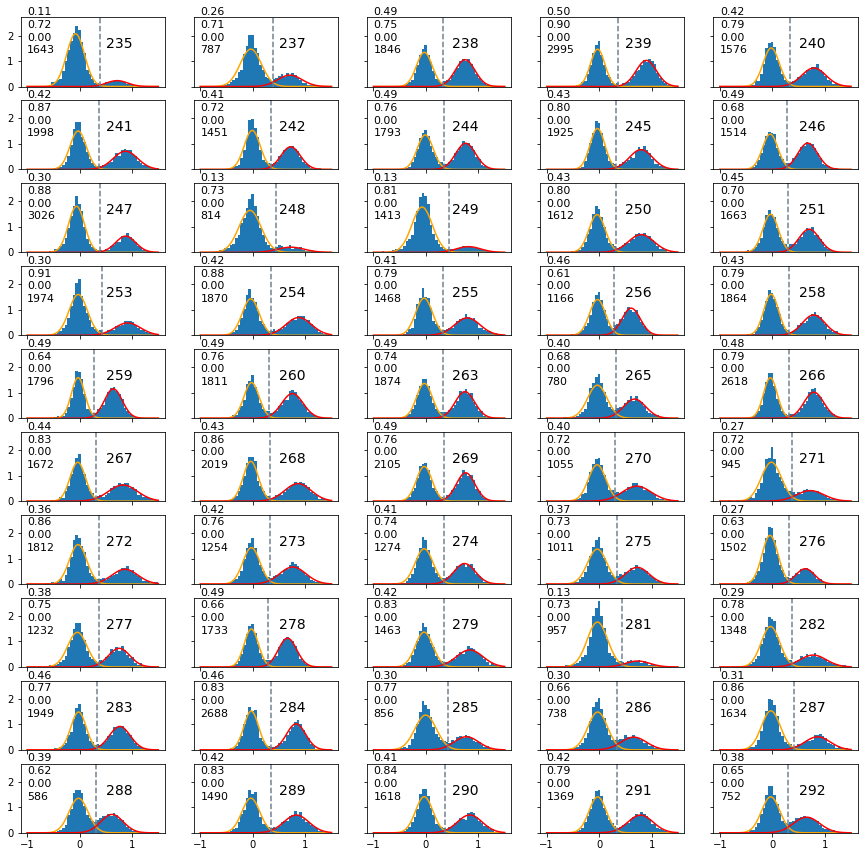

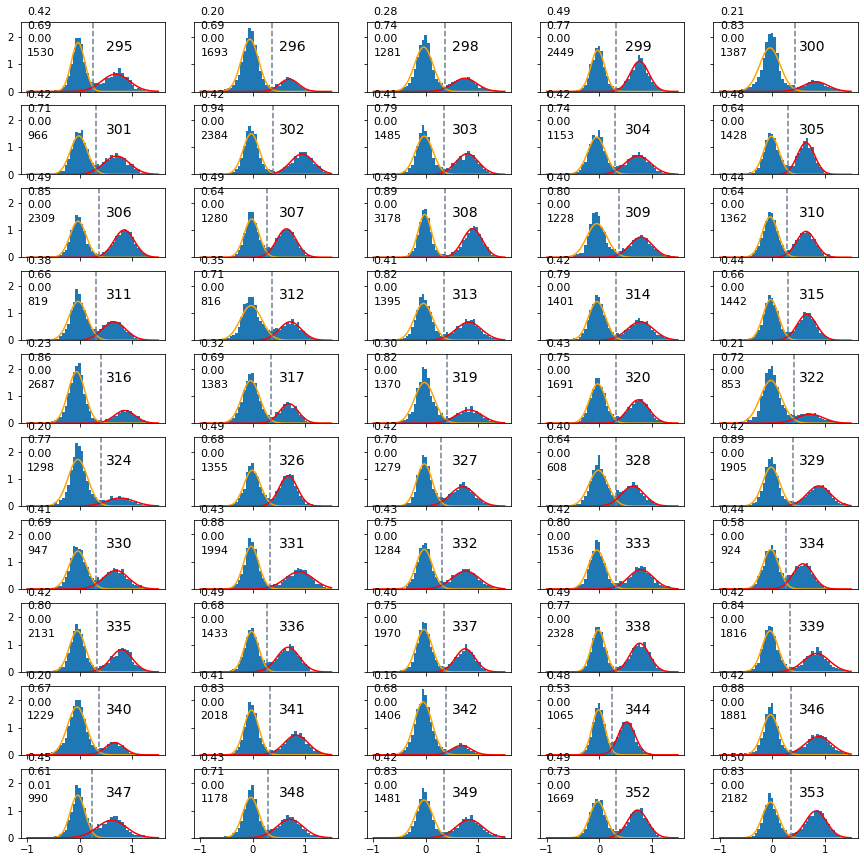

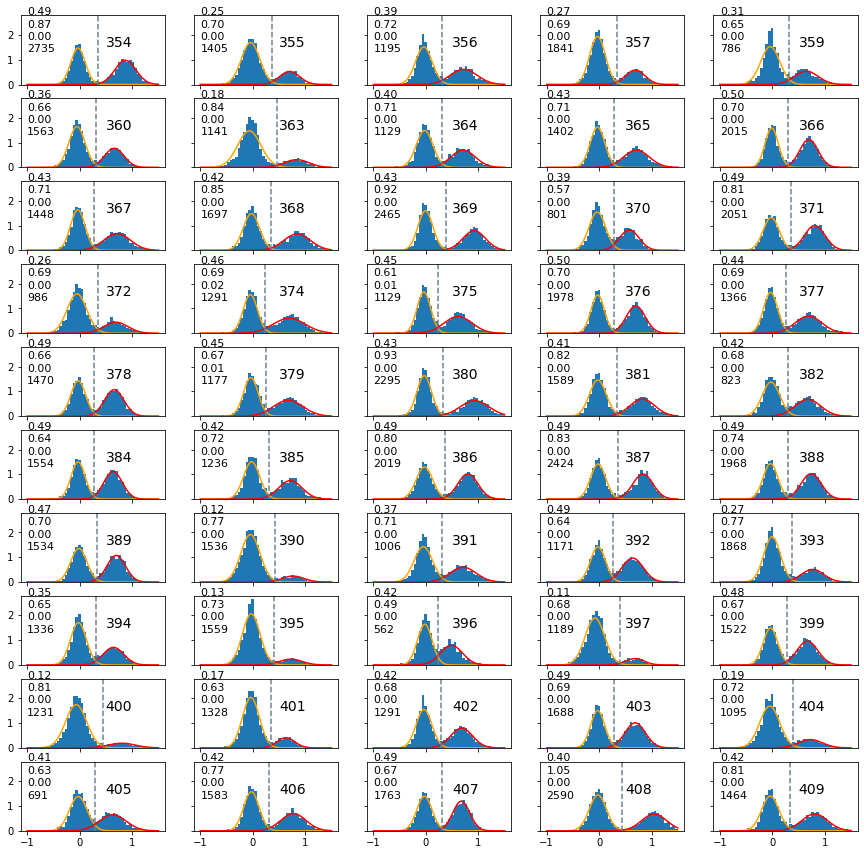

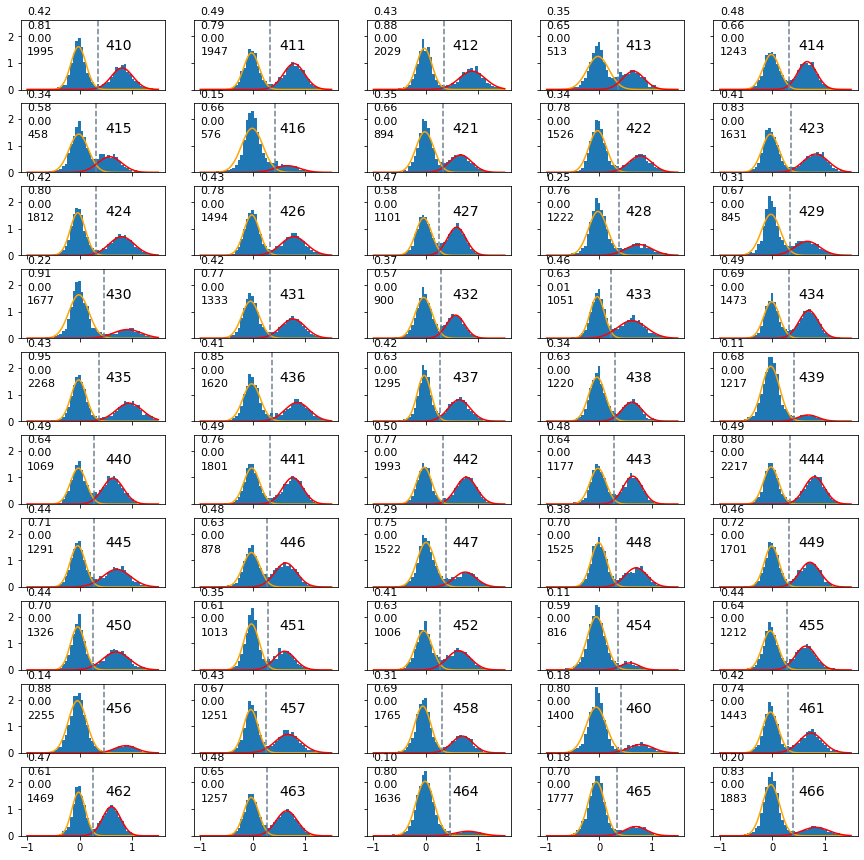

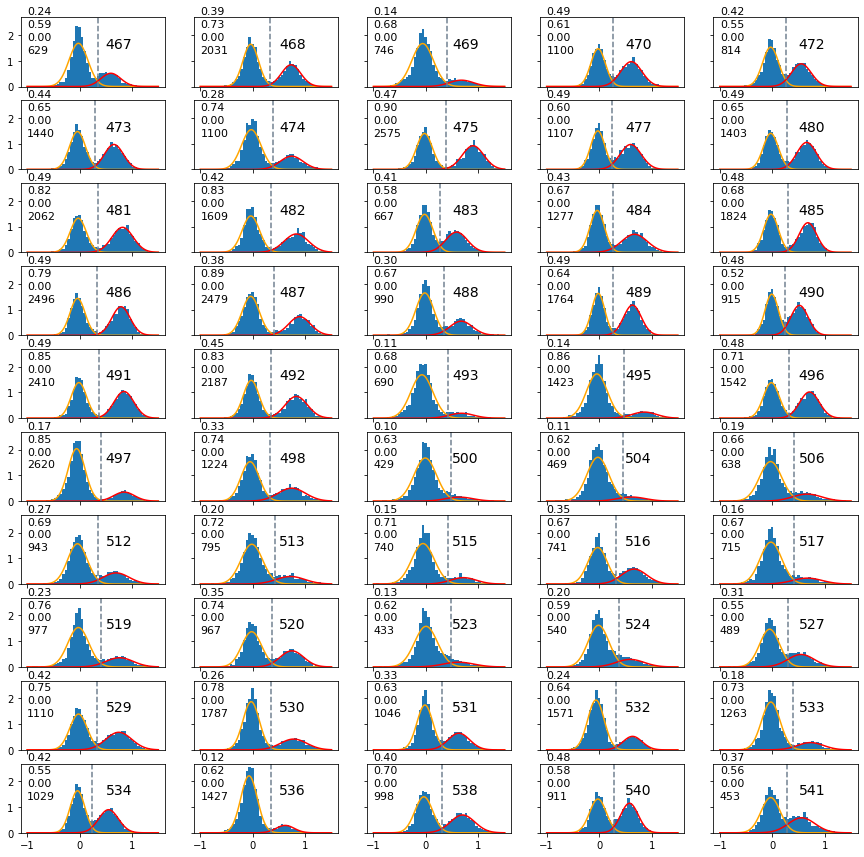

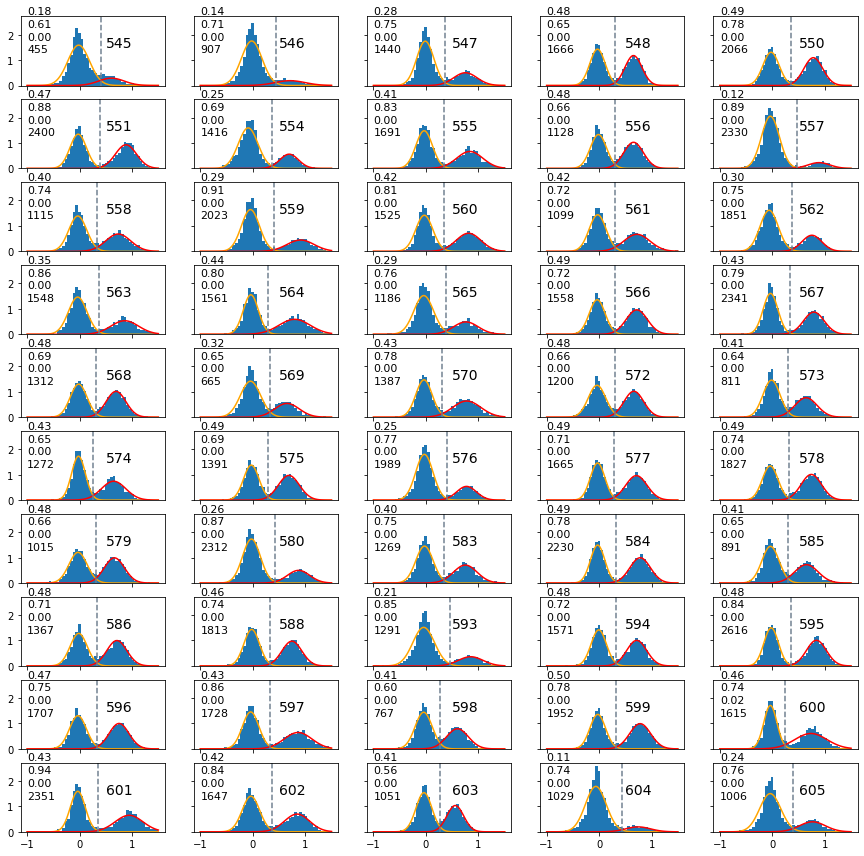

In [65]:
figw = 5
figh = 10
figind = 50

x=np.linspace(-1,1.5,100)

for b in tqdm(goodbase[0:500], position=0):
    
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    
    if figind >= (figw * figh):
        fig, ax = plt.subplots(figh, figw, figsize=(15, 15), sharex=True, sharey=True)
        figind = 0
        
    ax[int(figind / figw), figind % figw].hist(usedat, np.linspace(-1, 1.5, 50), density=True)
    for comp, col in [(0,'orange'), (1,'red')]:
        ax[int(figind / figw), figind % figw].plot(x, gmmFitd[b].weights_[comp]*norm.pdf(x, loc=gmmFitd[b].means_[comp][0], scale=np.sqrt(gmmFitd[b].covariances_[comp])), color=col)
    #ax[int(figind / figw), figind % figw].axvline(x=cutoff, ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].axvline(x=gmmfd['cutoff'][b], ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].text(.5,1.5, b, fontsize=14)
    ax[int(figind / figw), figind % figw].text(-1,2.8, '{:.2f}'.format(gmmfd['weighthigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,2.3, '{:.2f}'.format(gmmfd['meanhigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.8, '{:.2f}'.format(gmmfd['lowprob'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.3, '{:.0f}'.format(gmmfd['aicd'][b]), fontsize=11)
    figind += 1
    #plt.xlabel('residual')

In [152]:
import smm
from scipy.stats import t

minmol = min(residuals[0].shape[0], residuals[1].shape[0])
usemol0 = np.random.choice(np.arange(residuals[0].shape[0]), size=minmol, replace=False)
usemol1 = np.random.choice(np.arange(residuals[1].shape[0]), size=minmol, replace=False)
concdat = np.concatenate([residuals[0][usemol0,:], residuals[1][usemol1,:]])

gmmfd = {'basei':[], 'threshold':[], 'meanlow':[], 'meanhigh':[], 'weighthigh':[], 'lowcut':[],
         'lowprob':[], 'aicd':[], 'cutoff':[], 'converged':[]}

gmmFitd = {}

b = 87
dat = concdat[:,b]
usedat = dat[~np.isnan(dat)].reshape(-1,1)

mix_t = smm.SMM(n_components=2, covariance_type='full', n_iter=1000, tol=1e-6)

mix_t.fit(usedat)
xfine = np.linspace(0,1,1001)
preda = mix_t.predict_proba(xfine.reshape(-1,1))
tcutoff = xfine[np.abs(preda[:,1] - 0.5).argmin()]

gmm2 = GaussianMixture(2, covariance_type='spherical', tol=1e-6, means_init=np.array([0,0.75]).reshape(2,1))
gmm2.fit(usedat)
preda = gmm2.predict_proba(xfine.reshape(-1,1))
gcutoff = xfine[np.abs(preda[:,1] - 0.5).argmin()]

In [29]:
mix_t.degrees[0]

4.455282220494132

In [63]:
gmm2.covariances_

array([0.02607978, 0.06407952])

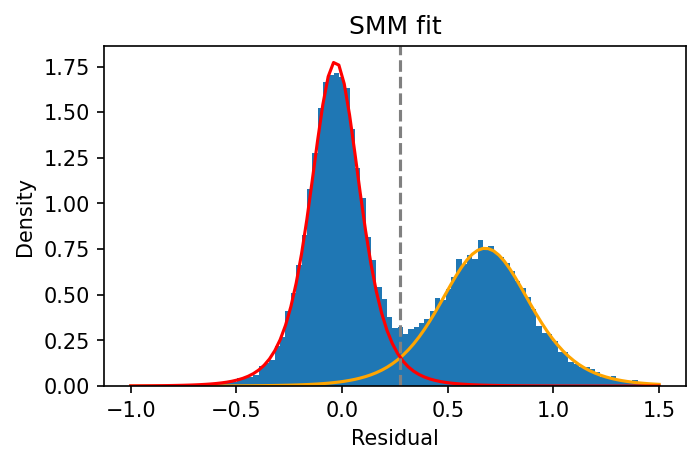

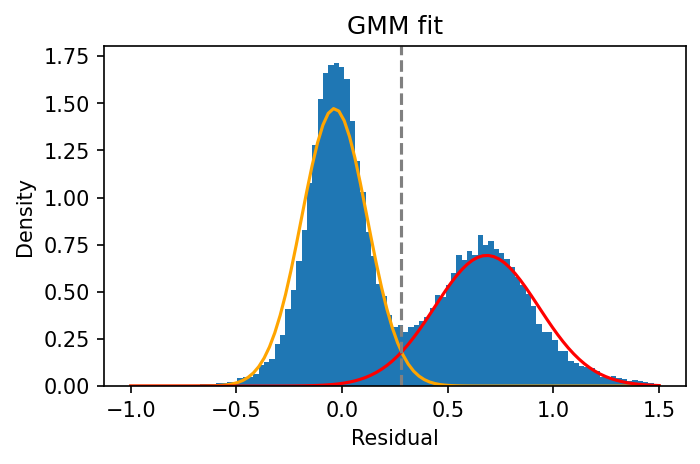

In [153]:
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 150

x=np.linspace(-1,1.5,100)

plt.figure(figsize=(5,3))
plt.hist(usedat, np.linspace(-1, 1.5, 100), density=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('SMM fit')
plt.plot(x, mix_t.weights[0] * t.pdf(x, df=mix_t.degrees[0], loc=mix_t.means[0][0],
                                     scale=np.sqrt(mix_t.covariances[0][0][0])), color='orange')
plt.plot(x, mix_t.weights[1] * t.pdf(x, df=mix_t.degrees[1], loc=mix_t.means[1][0],
                                     scale=np.sqrt(mix_t.covariances[1][0][0])), color='red')
plt.axvline(x=tcutoff, color='gray', ls='--')

plt.figure(figsize=(5,3))
plt.hist(usedat, np.linspace(-1, 1.5, 100), density=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('GMM fit')
plt.plot(x, gmm2.weights_[0] * norm.pdf(x, loc=gmm2.means_[0][0],
                                     scale=np.sqrt(gmm2.covariances_[0])), color='orange')
plt.plot(x, gmm2.weights_[1] * norm.pdf(x, loc=gmm2.means_[1][0],
                                     scale=np.sqrt(gmm2.covariances_[1])), color='red')
plt.axvline(x=gcutoff, color='gray', ls='--')

In [7]:
usedat.shape

(3120, 1)

In [ ]:
mix_tT = smm.SMM(n_components=2, covariance_type='spherical')
mix_tT.fit(usedat)

In [19]:
mix_t.means

array([[-0.01858448],
       [ 0.69080146]])

In [39]:
# new t-distribution mixture variant

import smm
from scipy.stats import t
import warnings
from sklearn.exceptions import ConvergenceWarning

minmol = min(residuals[0].shape[0], residuals[1].shape[0])
usemol0 = np.random.choice(np.arange(residuals[0].shape[0]), size=minmol, replace=False)
usemol1 = np.random.choice(np.arange(residuals[1].shape[0]), size=minmol, replace=False)
concdat = np.concatenate([residuals[0][usemol0,:], residuals[1][usemol1,:]])

smmfd = {'basei':[], 'threshold':[], 'meanlow':[], 'meanhigh':[], 'weighthigh':[], 'lowcut':[],
         'lowprob':[], 'aicd':[], 'cutoff':[]}

smmFitd = {}

for b in tqdm(range(residuals[0].shape[1]), position=0, smoothing=0):
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        smm1 = smm.SMM(1, tol=1e-6)
        smm1.fit(usedat)
        smm2 = smm.SMM(2, tol=1e-6, n_iter=1000)
        smm2.fit(usedat)
    smmFitd[b] = smm2
    
    xfine = np.linspace(0,1,1001)
    preda = smm2.predict_proba(xfine.reshape(-1,1))
    cutoff = xfine[np.abs(preda[:,1] - 0.5).argmin()]
    lowcut = preda[0,1]
    
    lowcomp = smm2.means_.flatten().argmin()
    highcomp = 1 - lowcomp
    
    smmfd['basei'].append(b)
    smmfd['threshold'].append(cutoff)
    smmfd['meanlow'].append(smm2.means_[lowcomp][0])
    smmfd['meanhigh'].append(smm2.means_[highcomp][0])
    smmfd['weighthigh'].append(smm2.weights_[highcomp])
    smmfd['lowcut'].append(lowcut)
    smmfd['lowprob'].append(smm2.predict_proba(np.array([-0.4]).reshape(-1,1))[0,highcomp])
    smmfd['aicd'].append(smm1.aic(usedat) - smm2.aic(usedat))
    smmfd['cutoff'].append(cutoff)
    
smmfd = pd.DataFrame(smmfd)

100%|██████████| 1762/1762 [1:30:55<00:00,  3.10s/it]


In [8]:
# new measurement, look at rate of calling in pos and neg control for the cutoff

posfrac = []
negfrac = []

for b in tqdm(range(residuals[0].shape[1]), position=0, smoothing=0):
    pdat = residuals[0][:,b]
    usepdat = pdat[~np.isnan(pdat)]
    
    posfrac.append(np.mean(usepdat > smmfd['cutoff'][b]))
    
    ndat = residuals[1][:,b]
    usendat = ndat[~np.isnan(ndat)]
    
    negfrac.append(np.mean(usendat > smmfd['cutoff'][b]))

posfrac = np.array(posfrac)
negfrac = np.array(negfrac)

100%|██████████| 1762/1762 [00:01<00:00, 1557.05it/s]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


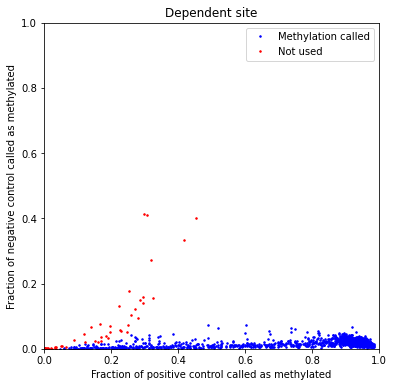

In [9]:
titleD = {'indep':'Independent site', 'dep':'Dependent site'}

plt.figure(figsize=(6,6))
plt.plot(posfrac[goodbase], negfrac[goodbase], 'b.', ms=3, label='Methylation called')
plt.plot(posfrac[badbase], negfrac[badbase], 'r.', ms=3, label='Not used')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Fraction of positive control called as methylated')
plt.ylabel('Fraction of negative control called as methylated')
plt.title(titleD[amplicon])
plt.legend()
plt.savefig('/data/users/goodarzilab/colin/Figures/smmControlFrac_' + amplicon + '.png', dpi=300)

0

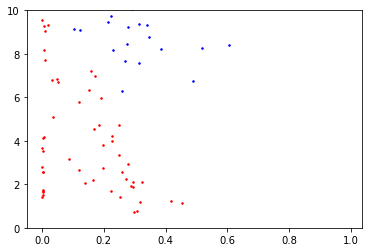

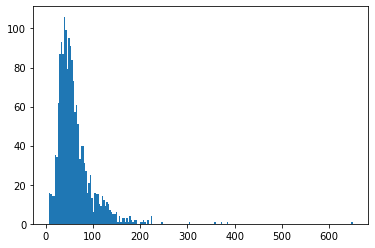

In [10]:
plt.plot(posfrac[goodbase], posfrac[goodbase]/negfrac[goodbase], 'b.', ms=3, label='Methylation called')
plt.plot(posfrac[badbase], posfrac[badbase]/negfrac[badbase], 'r.', ms=3, label='Not used')
plt.ylim([0,10])
plt.figure()
plt.hist(posfrac[goodbase]/negfrac[goodbase], 200)
0

In [40]:
dfrac = []
for b in tqdm(range(residuals[0].shape[1]), position=0, smoothing=0):
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    
    dfrac.append( np.mean( usedat > smmfd['cutoff'][b]))
dfrac = np.array(dfrac)

100%|██████████| 1762/1762 [00:00<00:00, 2768.14it/s]


In [13]:
dfrac.sort()
dfrac[0:40]

array([0.00028175, 0.00036004, 0.00074318, 0.00094114, 0.00106805,
       0.00127191, 0.00142432, 0.00152855, 0.00155145, 0.00227029,
       0.00249307, 0.00282278, 0.0029994 , 0.00302784, 0.00366279,
       0.00375897, 0.00388139, 0.00391633, 0.00419724, 0.00473555,
       0.00582325, 0.00647739, 0.00966254, 0.00973849, 0.0141848 ,
       0.01585355, 0.01631289, 0.01913732, 0.02336758, 0.02575732,
       0.02750957, 0.02998932, 0.0311006 , 0.03120352, 0.03723391,
       0.0384352 , 0.03941773, 0.03969586, 0.04083146, 0.04134139])

0

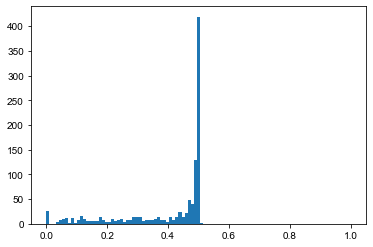

In [27]:
plt.hist(dfrac, np.linspace(0,1,100))
0

In [41]:
if amplicon == 'indep':
    passfilt = np.logical_and.reduce([(smmfd['meanhigh'] - smmfd['meanlow']).to_numpy() > 0.2,
                                      smmfd['meanhigh'] > 0,
                                      dfrac > 0.02])

if amplicon == 'dep':
    passfilt = np.logical_and.reduce([(smmfd['meanhigh'] - smmfd['meanlow']).to_numpy() > 0.1,
                                      smmfd['meanhigh'] > 0,
                                      dfrac > 0.02])
    
if amplicon == 'widom':
    passfilt = np.logical_and.reduce([(smmfd['meanhigh'] - smmfd['meanlow']).to_numpy() > 0.3,
                                      smmfd['meanhigh'] > 0,
                                      dfrac > 0.02])
    
goodbase = np.nonzero(passfilt)[0]
badbase = np.nonzero(~passfilt)[0]
    
print(len(goodbase))
print(len(badbase))

1698
64


In [42]:
# now apply threshhold to all samples
#useSamples = {'indep':indepSamples, 'dep':depSamples, 'widom':[3, 44, 45, 47, 48, 51, 52]}
useSamples = {'indep':np.append([0,1], redoInd), 'dep':np.append([2,3], redoDep), 'widom':[3, 44, 45, 47, 48, 51, 52]}
for samp in tqdm(useSamples[amplicon], position=0):
    with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','NNres',
                               sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_residuals.npz')) as data:
        resid = data['residuals']
        
    methbin = np.full(resid.shape, np.nan, dtype=np.float32)
    
    for b in range(methbin.shape[1]):
        if b in goodbase:
            hasmeasure = ~np.isnan(resid[:,b])
            methbin[hasmeasure,b] = resid[hasmeasure,b] > smmfd['threshold'][b]
            
    if not os.path.exists(dataPBase + '%s/processed/binarized' % (sampleRef['cell'][samp])):
        os.makedirs(dataPBase + '%s/processed/binarized' % (sampleRef['cell'][samp]))
        
    np.savez(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','binarized',
                               sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_binarized_SMM.npz'),
             methpred = methbin)

100%|██████████| 14/14 [00:28<00:00,  2.06s/it]


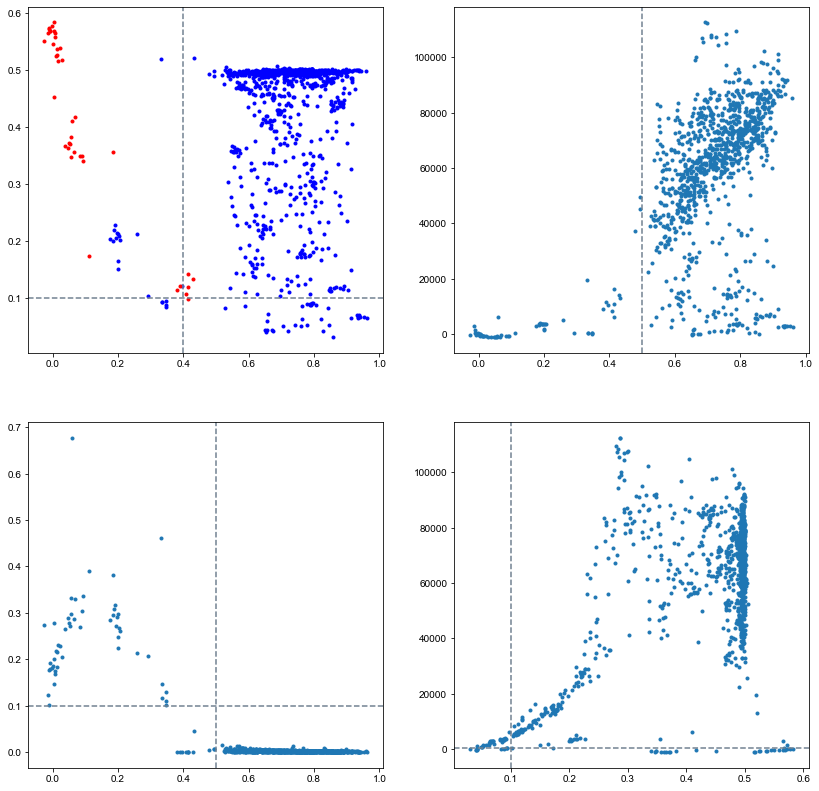

In [21]:
fig, ax = plt.subplots(2,2, figsize=(14,14))
ax[0,0].plot(smmfd['meanhigh'][goodbase], smmfd['weighthigh'][goodbase], 'b.')
ax[0,0].plot(smmfd['meanhigh'][badbase], smmfd['weighthigh'][badbase], 'r.')
ax[0,0].axvline(x=0.4, ls='--', color='slategray')
ax[0,0].axhline(y=0.1, ls='--', color='slategray')

ax[0,1].plot(smmfd['meanhigh'], smmfd['aicd'], '.')
ax[0,1].axvline(x=0.5, ls='--', color='slategray')

ax[1,0].plot(smmfd['meanhigh'], smmfd['lowprob'], '.')
ax[1,0].axvline(x=0.5, ls='--', color='slategray')
ax[1,0].axhline(y=0.1, ls='--', color='slategray')


ax[1,1].plot(smmfd['weighthigh'], smmfd['aicd'], '.')
ax[1,1].axvline(x=0.1, ls='--', color='slategray')
ax[1,1].axhline(y=300, ls='--', color='slategray')


100%|██████████| 53/53 [00:08<00:00,  6.46it/s]


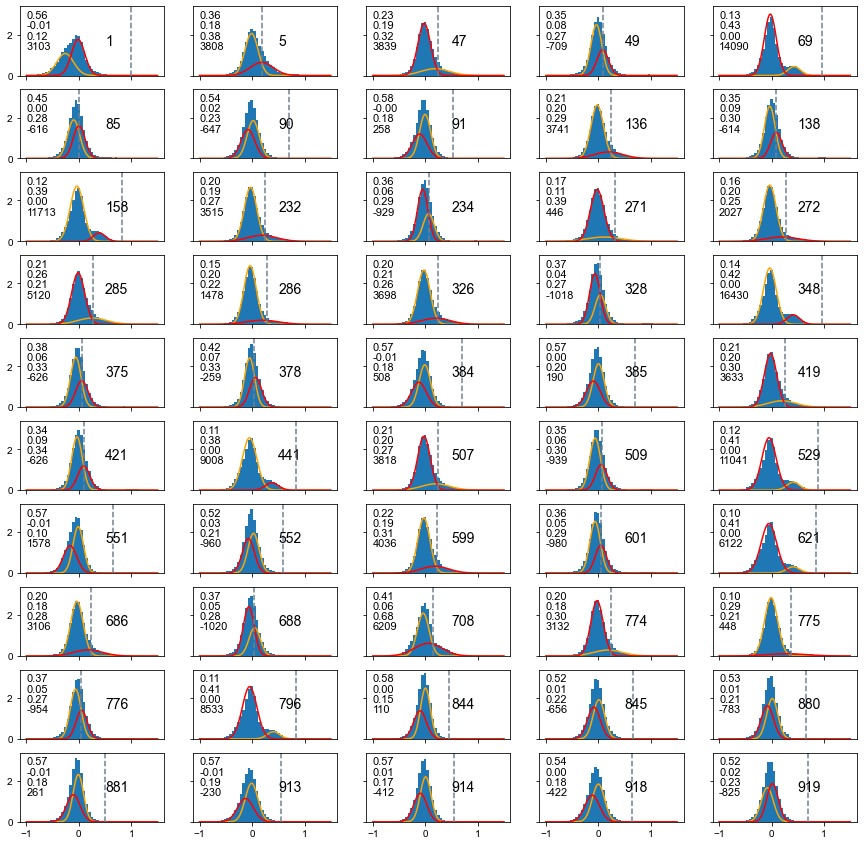

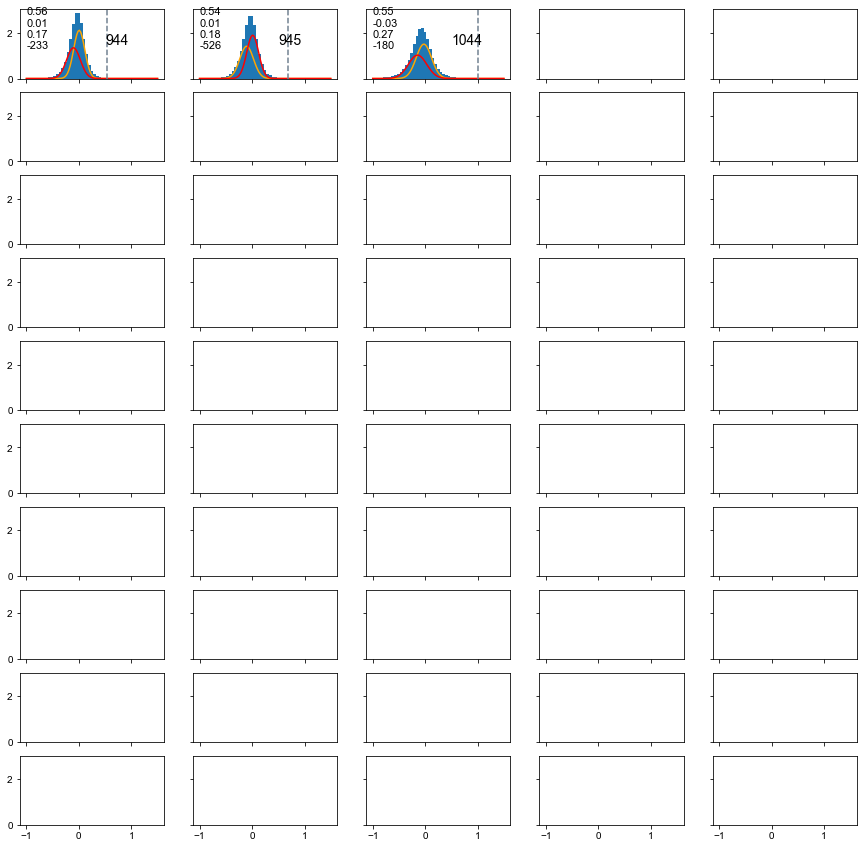

In [25]:
figw = 5
figh = 10
figind = 50

x=np.linspace(-1,1.5,100)

for b in tqdm(badbase[0:200], position=0):
    
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    
    if figind >= (figw * figh):
        fig, ax = plt.subplots(figh, figw, figsize=(15, 15), sharex=True, sharey=True)
        figind = 0
        
    ax[int(figind / figw), figind % figw].hist(usedat, np.linspace(-1, 1.5, 50), density=True)
    for comp, col in [(0,'orange'), (1,'red')]:
        ax[int(figind / figw), figind % figw].plot(x, smmFitd[b].weights[comp]*norm.pdf(x, loc=smmFitd[b].means[comp][0], scale=np.sqrt(smmFitd[b].covariances[comp][0][0])), color=col)
    #ax[int(figind / figw), figind % figw].axvline(x=cutoff, ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].axvline(x=smmfd['cutoff'][b], ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].text(.5,1.5, b, fontsize=14)
    ax[int(figind / figw), figind % figw].text(-1,2.8, '{:.2f}'.format(smmfd['weighthigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,2.3, '{:.2f}'.format(smmfd['meanhigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.8, '{:.2f}'.format(smmfd['lowprob'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.3, '{:.0f}'.format(smmfd['aicd'][b]), fontsize=11)
    figind += 1
    #plt.xlabel('residual')

100%|██████████| 992/992 [02:29<00:00,  6.64it/s]


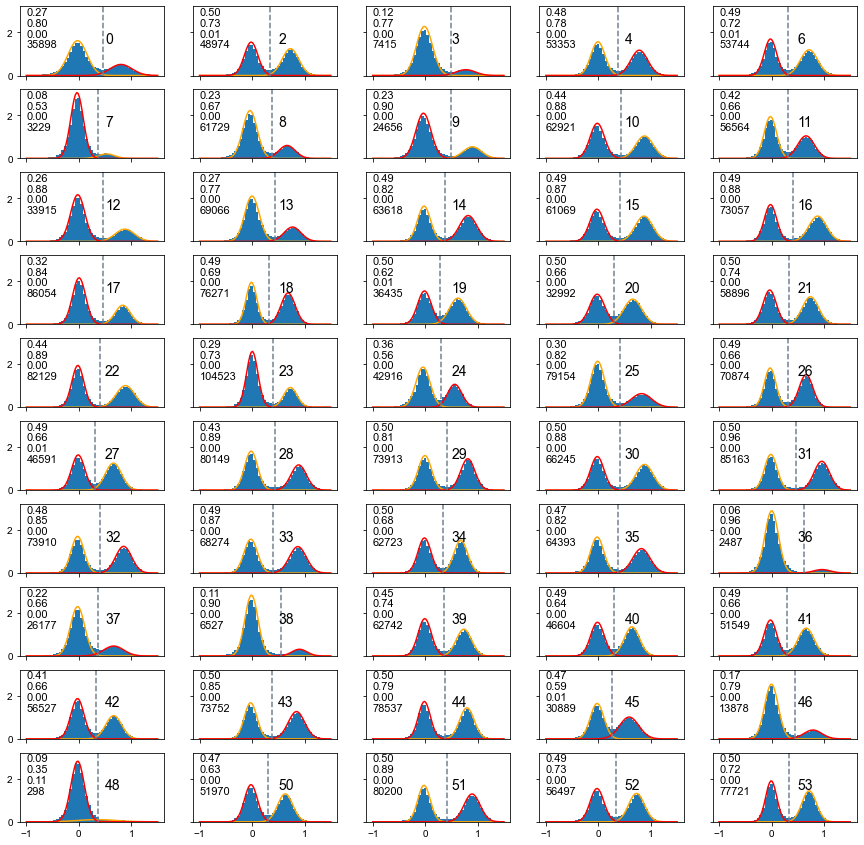

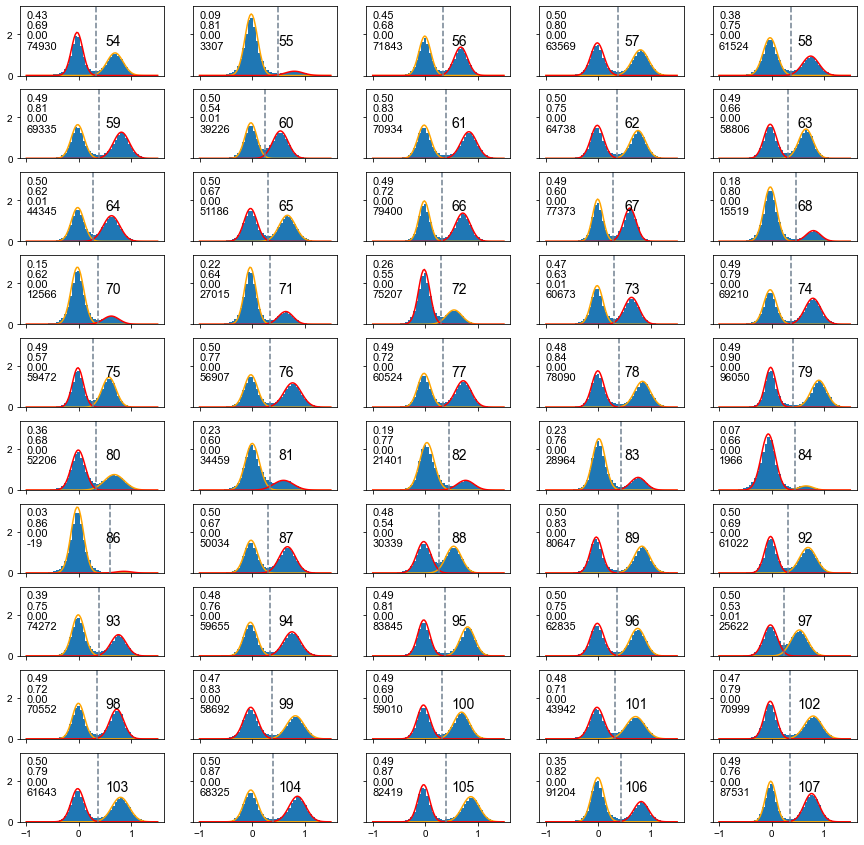

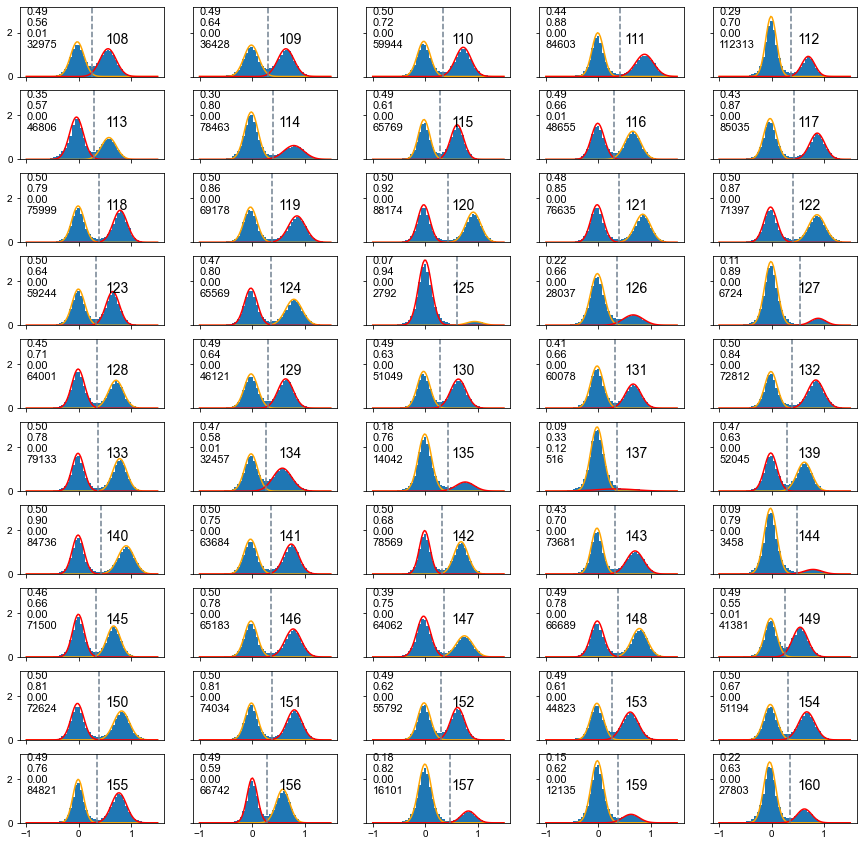

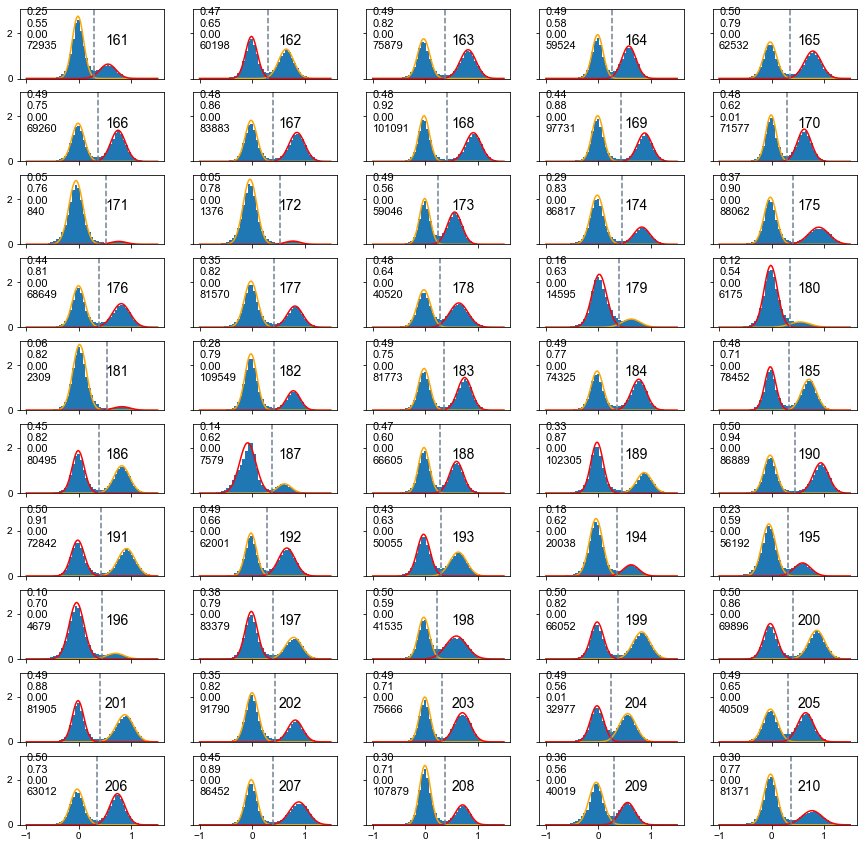

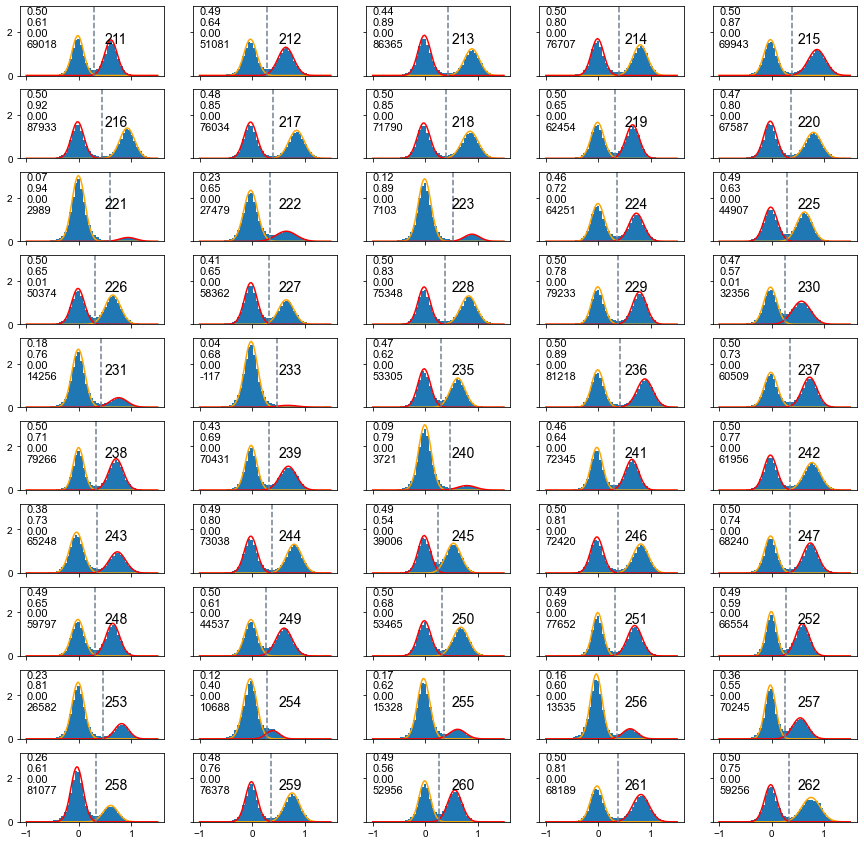

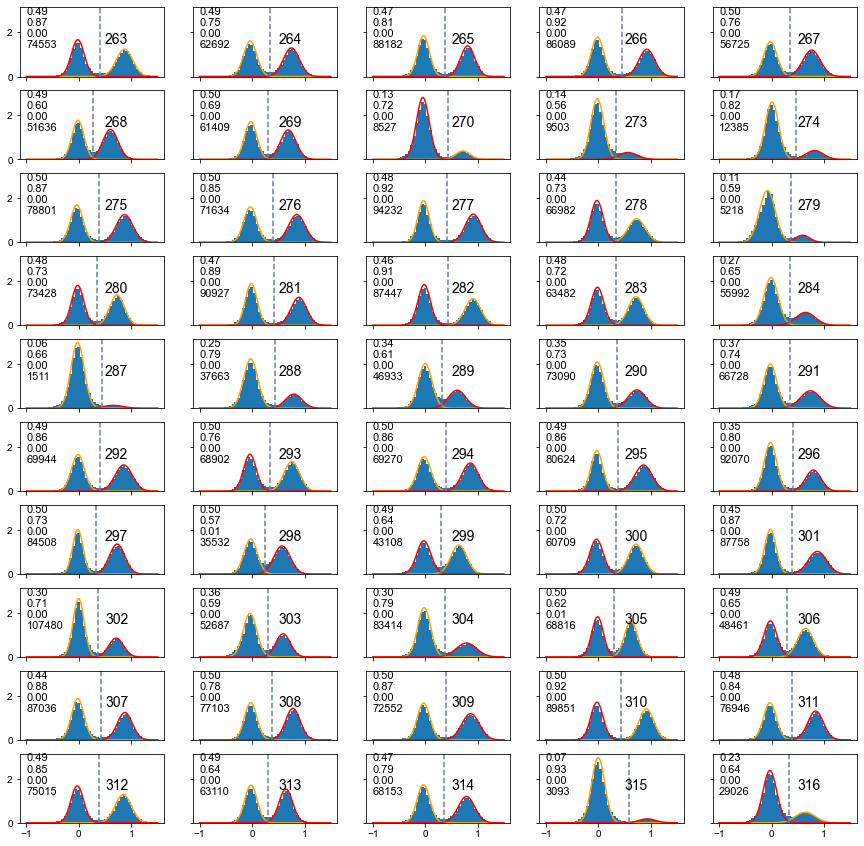

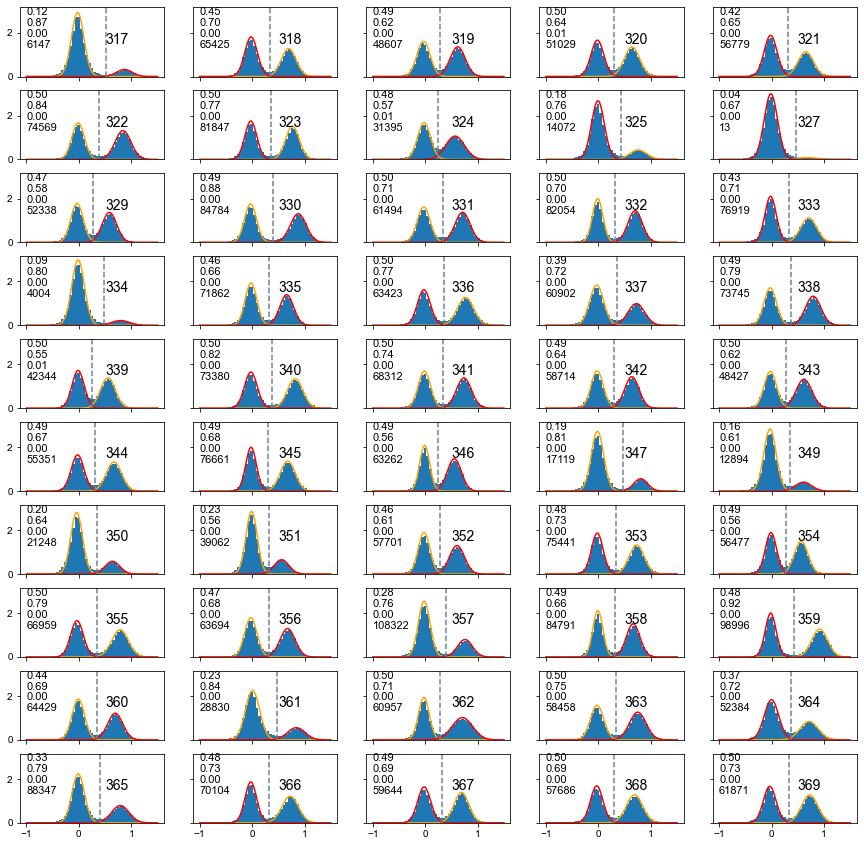

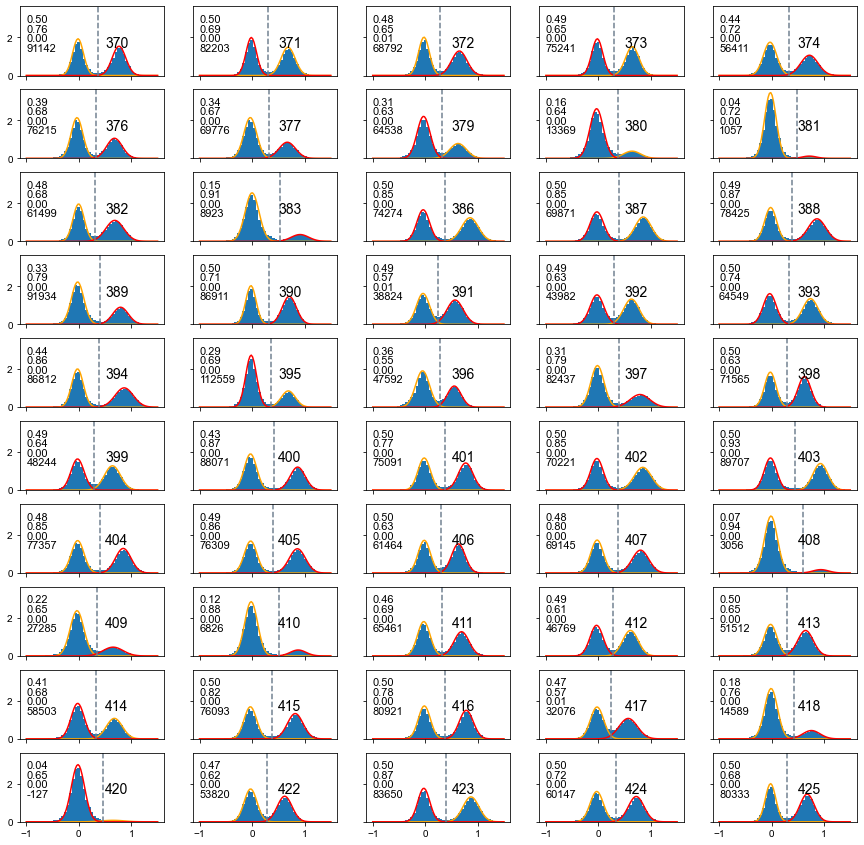

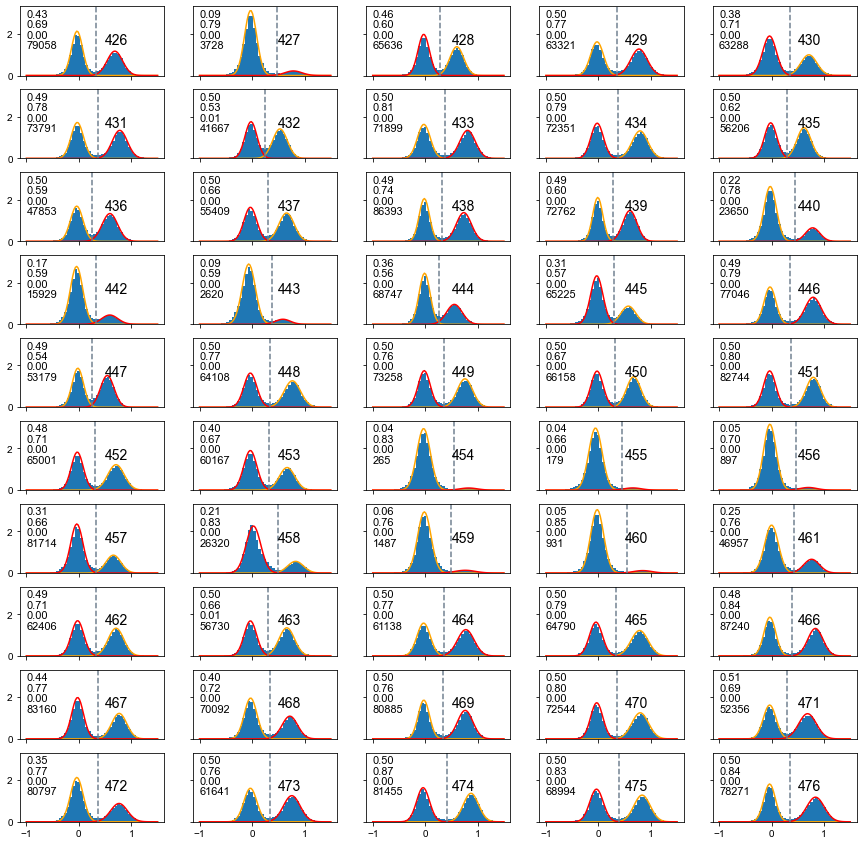

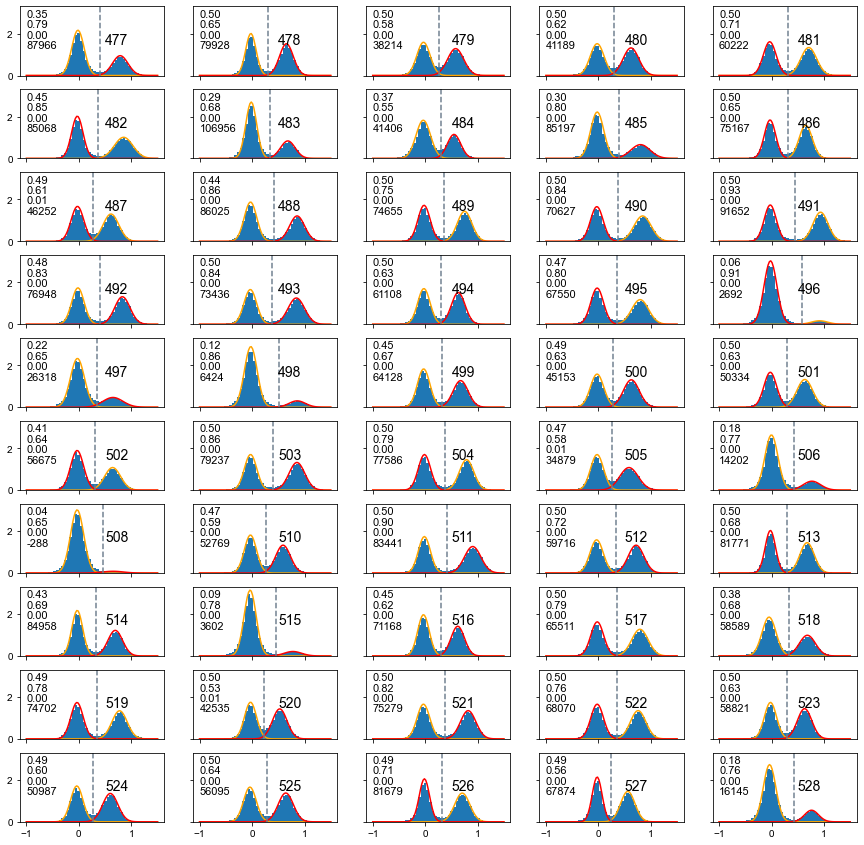

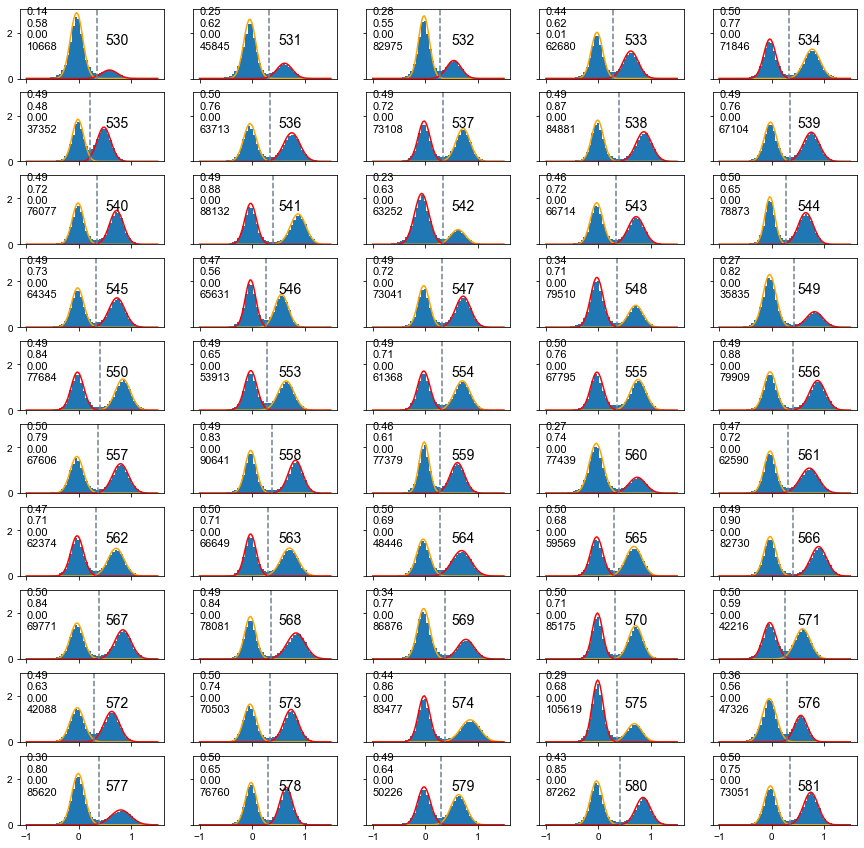

Error in callback <function flush_figures at 0x7f0a39c9e8b0> (for post_execute):


KeyboardInterrupt: 

In [26]:
figw = 5
figh = 10
figind = 50

x=np.linspace(-1,1.5,100)

for b in tqdm(goodbase[0:1000], position=0):
    
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    
    if figind >= (figw * figh):
        fig, ax = plt.subplots(figh, figw, figsize=(15, 15), sharex=True, sharey=True)
        figind = 0
        
    ax[int(figind / figw), figind % figw].hist(usedat, np.linspace(-1, 1.5, 50), density=True)
    for comp, col in [(0,'orange'), (1,'red')]:
        ax[int(figind / figw), figind % figw].plot(x, smmFitd[b].weights[comp]*norm.pdf(x, loc=smmFitd[b].means[comp][0], scale=np.sqrt(smmFitd[b].covariances[comp][0][0])), color=col)
    #ax[int(figind / figw), figind % figw].axvline(x=cutoff, ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].axvline(x=smmfd['cutoff'][b], ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].text(.5,1.5, b, fontsize=14)
    ax[int(figind / figw), figind % figw].text(-1,2.8, '{:.2f}'.format(smmfd['weighthigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,2.3, '{:.2f}'.format(smmfd['meanhigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.8, '{:.2f}'.format(smmfd['lowprob'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.3, '{:.0f}'.format(smmfd['aicd'][b]), fontsize=11)
    figind += 1
    #plt.xlabel('residual')

In [3]:
# now calc accessibility likelihood over 25bp windows

refs = {'indep':irefseq, 'dep':drefseq, 'widom':None}
posControl = {'indep':0, 'dep':2}
negControl = {'indep':1, 'dep':3}
useSamples = {'indep':indepSamples, 'dep':depSamples, 'widom':[3, 44, 45, 47, 48, 51, 52]}

for amplicon in ['indep', 'dep']:
    refseq = refs[amplicon]
    possamp = posControl[amplicon]
    negsamp = negControl[amplicon]

    bins = {}
    for samp in useSamples[amplicon]:
        with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','binarized',
                                   sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_binarized_SMM.npz')) as data:
            bins[samp] = data['methpred']

    goodInd = np.sum(np.isnan(bins[negsamp]), axis=0) < bins[negsamp].shape[0]

    refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T']}
    abaseInd = np.nonzero(np.logical_or(refis['A'], refis['T']))[0]

    goodBase = abaseInd[goodInd]

    goodIndInd = np.nonzero(goodInd)[0]


    # Find the probability of each good base being methylated in negative and positive controls  
    posmprob = np.full((len(abaseInd)), np.nan)
    for i in range(len(abaseInd)):
        if goodInd[i]:
            hasmeasure = ~np.isnan(bins[possamp][:,i])
            posmprob[i] = (np.sum(bins[possamp][hasmeasure,i] == 1) + 1) / (np.sum(hasmeasure) + 1)

    negmprob = np.full((len(abaseInd)), np.nan)
    for i in range(len(abaseInd)):
        if goodInd[i]:
            hasmeasure = ~np.isnan(bins[negsamp][:,i])
            negmprob[i] = (np.sum(bins[negsamp][hasmeasure,i] == 1) + 1) / (np.sum(hasmeasure) + 1)

    lposprob = np.log10(posmprob)
    lnegprob = np.log10(negmprob)
    lposnotprob = np.log10(1 - posmprob)
    lnegnotprob = np.log10(1 - negmprob)

    for lprob in [lposprob, lnegprob, lposnotprob, lnegnotprob]:
        lprob[np.isnan(lprob)] = 0

    # Get likelihoods
    lmethlike = lposprob - lnegprob
    lnotlike = lposnotprob - lnegnotprob

    convWindow = np.full((25), 1)

    for testsamp in useSamples[amplicon]:
        accessLikelihood = np.full((bins[testsamp].shape[0], len(refseq)), np.nan, dtype=np.float32)

        for imol in tqdm(range(bins[testsamp].shape[0]), position=0, smoothing=0, desc=sampleRef['sampleName'][testsamp]):
            thismol = np.full(len(refseq), 0.0, dtype=np.float32)
            yesmeth = bins[testsamp][imol,:] == 1
            nometh = bins[testsamp][imol,:] == 0
            thismol[abaseInd[yesmeth]] = lmethlike[yesmeth]
            thismol[abaseInd[nometh]] = lnotlike[nometh]

            accessLikelihood[imol,:] = np.convolve(thismol, convWindow, "same")

        np.savez(os.path.join(dataPBase, sampleRef['cell'][testsamp],'processed','binarized',
                                   sampleRef['cell'][testsamp] + '_' + sampleRef['sampleName'][testsamp] + '_NNsimpleSMM_access_likelihood_25bp.npz'),
                 accessLikelihood = accessLikelihood)

CTCF_Dep_5to1_plusADP_MT_rep1: 100%|██████████| 7527/7527 [00:00<00:00, 9202.93it/s]


In [4]:
lposprob.shape

(1679,)

In [13]:
# Get likelihoods
lmethlike = lposprob - lnegprob
lnotlike = lposnotprob - lnegnotprob

# move the log likelihoods to original locations

lmethL = np.full(len(refseq), 0, np.float32)
lnotL = np.full(len(refseq), 0, np.float32)

lmethL[abaseInd] = lmethlike
lnotL[abaseInd] = lnotlike

convWindow = np.full((25), 1)

accessLikelihood = np.full((bins[testsamp].shape[0], len(refseq)), np.nan, dtype=np.float32)
for imol in tqdm(range(bins[testsamp].shape[0]), position=0, smoothing=0, desc=sampleRef['sampleName'][testsamp]):
    thismol = np.full(len(refseq), 0.0, dtype=np.float32)
    yesmeth = bins[testsamp][imol,:] == 1
    nometh = bins[testsamp][imol,:] == 0
    thismol[abaseInd[yesmeth]] = lmethlike[yesmeth]
    thismol[abaseInd[nometh]] = lnotlike[nometh]
    
    accessLikelihood[imol,:] = np.convolve(thismol, convWindow, "same")

IndepArray_20to1_plusM: 100%|██████████| 41820/41820 [00:03<00:00, 11655.28it/s]


In [15]:
alnew = accessLikelihood
alnew.shape

(41820, 2706)

In [16]:
with np.load(os.path.join(dataPBase, sampleRef['cell'][testsamp],'processed','binarized',
                               sampleRef['cell'][testsamp] + '_' + sampleRef['sampleName'][testsamp] + '_NNsimpleSMM_access_likelihood_25bp.npz')) as data:
    alold = data['accessLikelihood']

In [17]:
alold.shape

(41820, 2706)

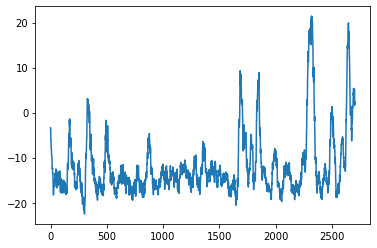

In [22]:
plt.plot(alnew[500,:])

## Looking at effectiveness of methylation calls / likelihood
21/06/07

In [ ]:
sampleRef.iloc[indepSamples]

In [155]:
amplicon = 'indep'

refs = {'indep':irefseq, 'dep':drefseq, 'widom':None}
posControl = {'indep':0, 'dep':2}
negControl = {'indep':1, 'dep':3}

refseq = refs[amplicon]
refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T']}
abaseInd = np.nonzero(np.logical_or(refis['A'], refis['T']))[0]

residuals = {}

for samp in [posControl[amplicon],negControl[amplicon], 12,13,14,15]:
    with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','NNres',
                               sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_residuals.npz')) as data:
        residuals[samp] = data['residuals']

In [26]:
b = 505

xcut = np.linspace(-0.5, 1.5, 1000)

posfrac = {}

for samp in [posControl[amplicon],negControl[amplicon], 12,13,14,15]:
    x = np.full(len(xcut), -1, 'float64')
    for i in range(len(xcut)):
        x[i] = np.nanmean(residuals[samp][:,b] > xcut[i])
    posfrac[samp] = x

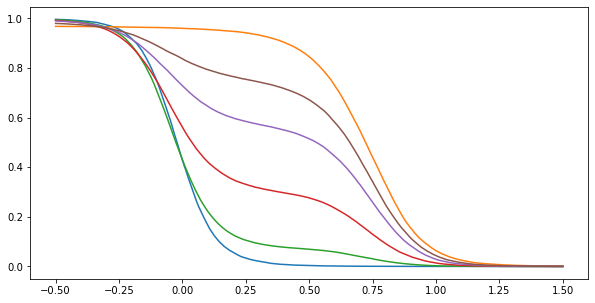

In [27]:
plt.figure(figsize=(10,5))

plt.plot(xcut, posfrac[negControl[amplicon]])
plt.plot(xcut, posfrac[posControl[amplicon]])
plt.plot(xcut, posfrac[12])
plt.plot(xcut, posfrac[13])
plt.plot(xcut, posfrac[14])
plt.plot(xcut, posfrac[15])

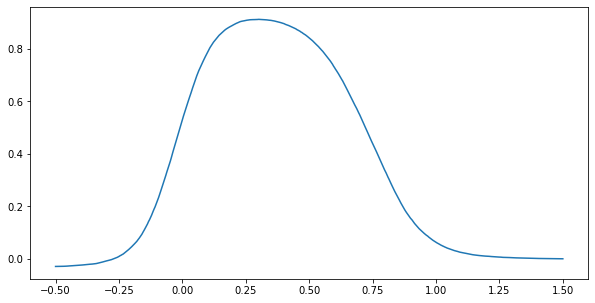

In [28]:
plt.figure(figsize=(10,5))

plt.plot(xcut, posfrac[posControl[amplicon]] - posfrac[negControl[amplicon]])

Text(0, 0.5, 'Density')

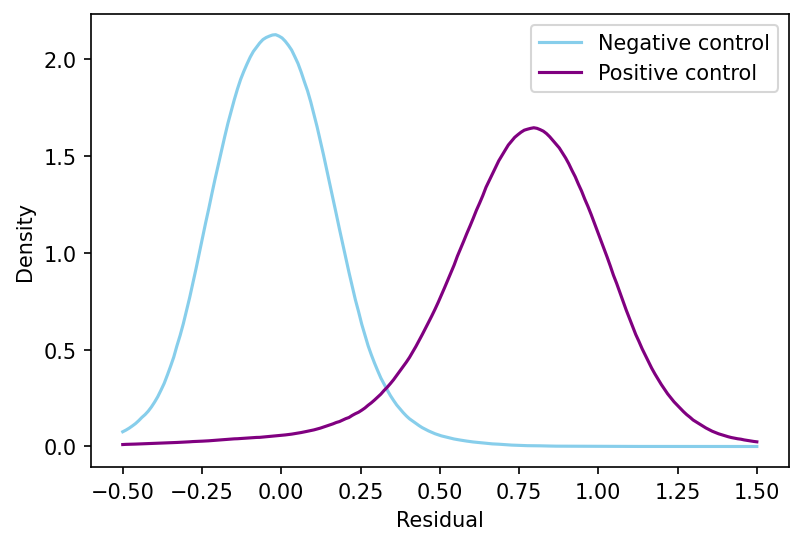

In [159]:
from sklearn.neighbors import KernelDensity

b = 87

pdat = residuals[posControl[amplicon]][:,b]
pdat = pdat[~np.isnan(pdat)].reshape(-1,1)
kdep = KernelDensity(kernel='tophat', bandwidth=.2).fit(pdat)
ndat = residuals[negControl[amplicon]][:,b]
ndat = ndat[~np.isnan(ndat)].reshape(-1,1)
kden = KernelDensity(kernel='tophat', bandwidth=.2).fit(ndat)

x_plot = np.linspace(-0.5, 1.5, 200).reshape(-1,1)

ldenp = kdep.score_samples(x_plot)
ldenn = kden.score_samples(x_plot)

plt.figure()
plt.plot(x_plot, np.exp(ldenn), color='skyblue', label='Negative control')
plt.plot(x_plot, np.exp(ldenp), color='purple', label='Positive control')
plt.legend()
plt.xlabel('Residual')
plt.ylabel('Density')

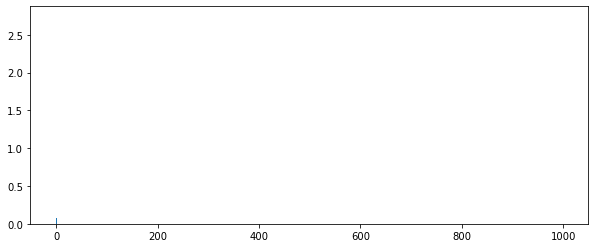

In [69]:
plt.figure(figsize=(10,4))
plt.hist(usedat, np.linspace(-1, 1.5, 50), density=True)
for comp, col in [(0,'orange'), (1,'red')]:
        plt.plot(x, smm2.weights[comp]*t.pdf(x, df=smm2.degrees[comp], loc=smm2.means[comp][0], scale=np.sqrt(smm2.covariances[comp][0][0])), color=col)

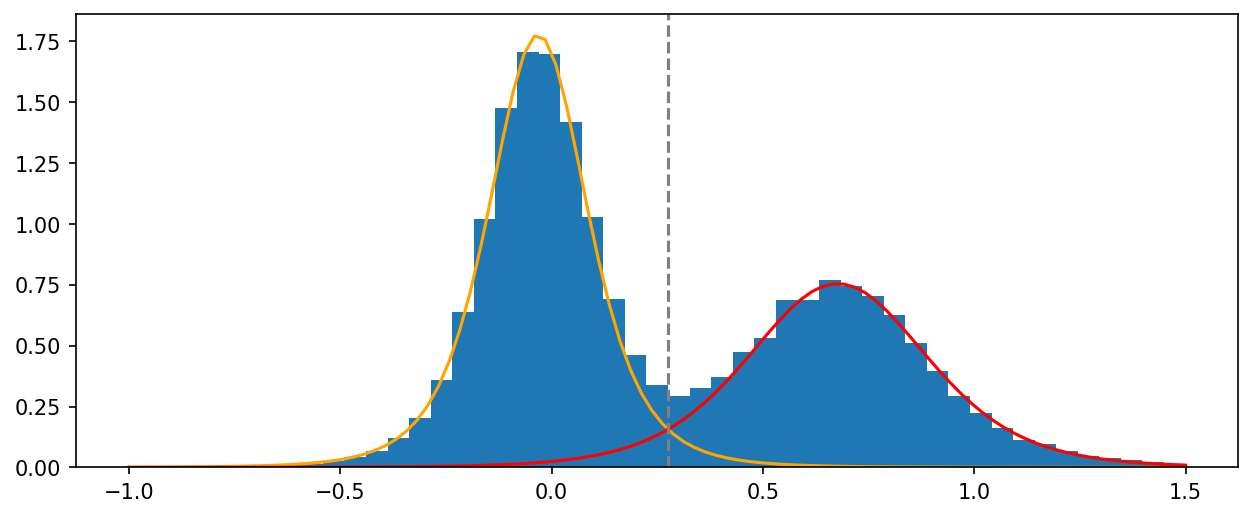

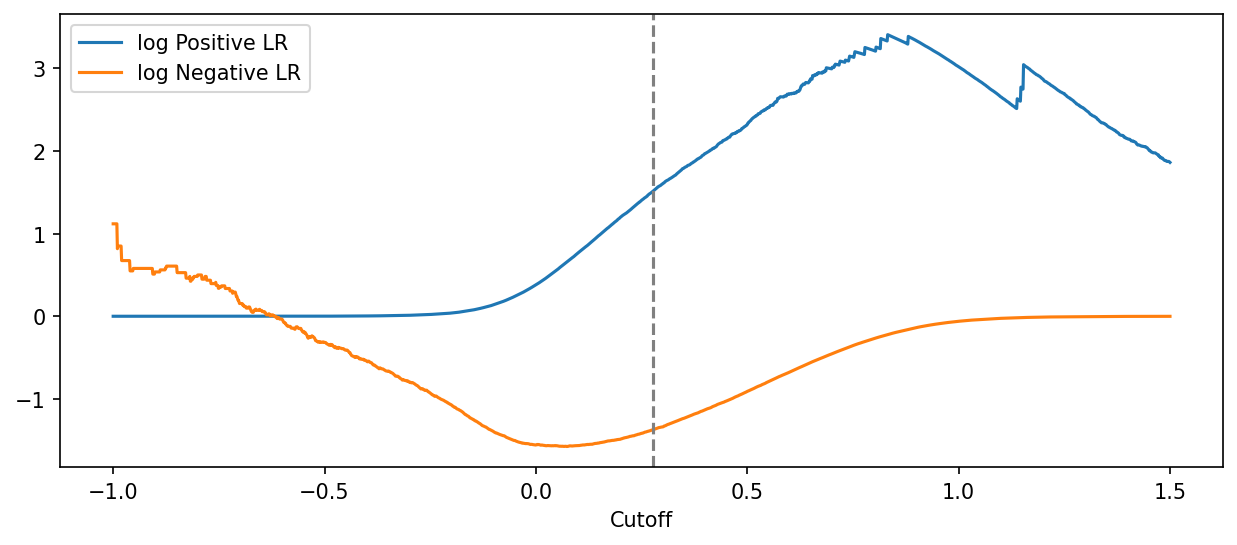

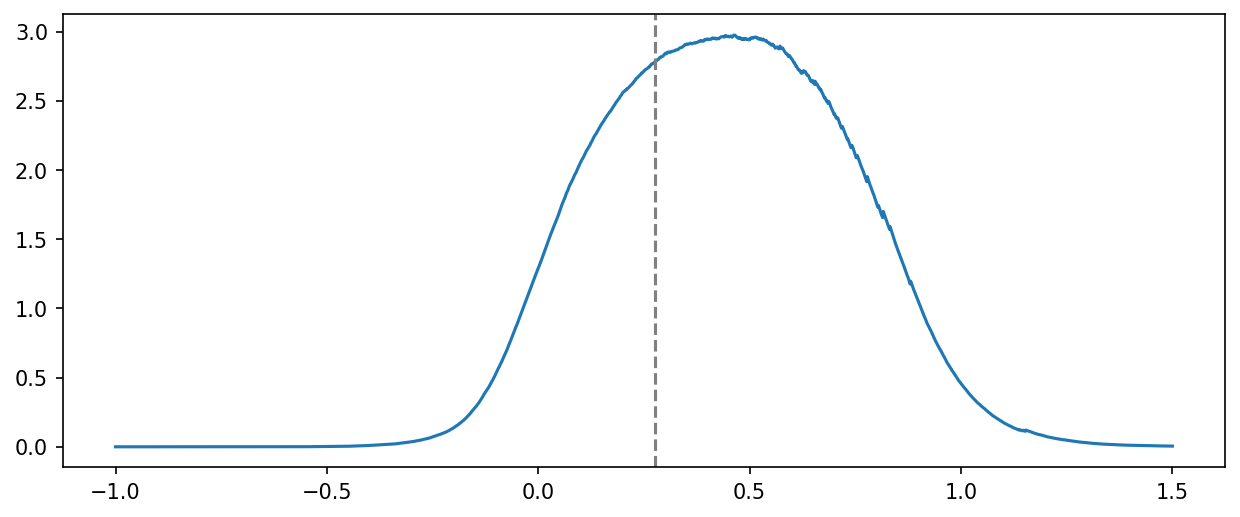

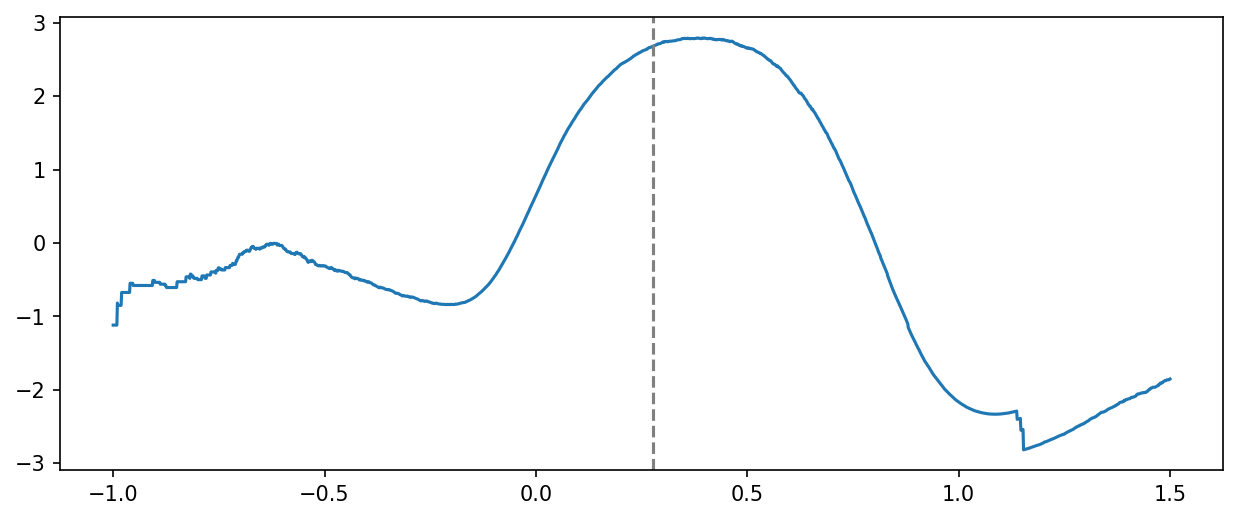

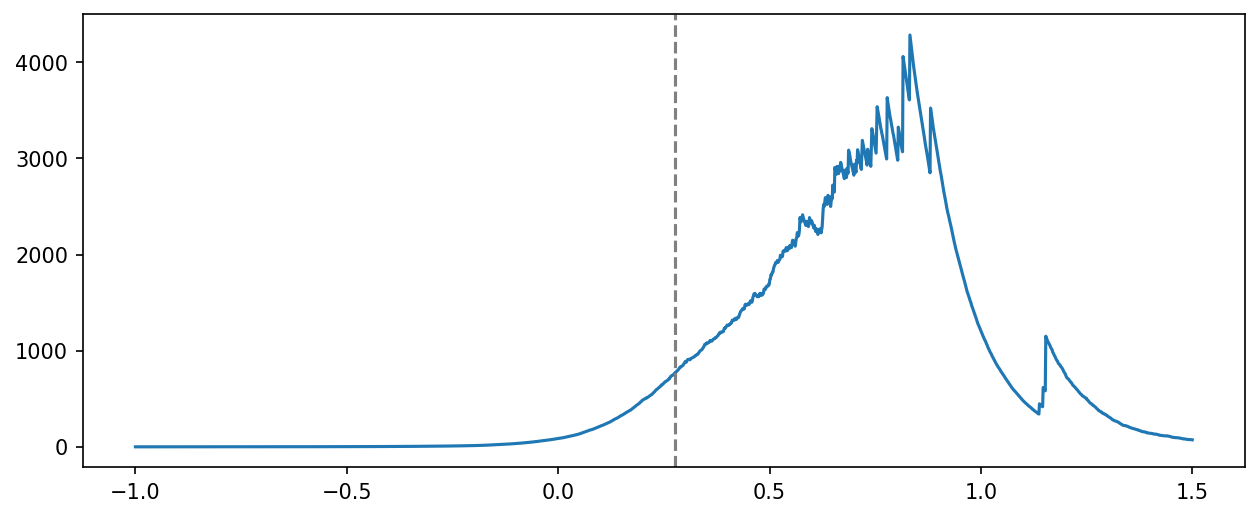

In [170]:
import warnings
from sklearn.exceptions import ConvergenceWarning

for b in [87]:

    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        smm2 = smm.SMM(2, tol=1e-6, n_iter=1000)
        smm2.fit(usedat)
    
    xfine = np.linspace(0,1,1001)
    preda = smm2.predict_proba(xfine.reshape(-1,1))
    cutoff = xfine[np.abs(preda[:,1] - 0.5).argmin()]
    
    x_curve = np.linspace(-1,1.5,100)
    plt.figure(figsize=(10,4))
    plt.hist(usedat, np.linspace(-1, 1.5, 50), density=True)
    for comp, col in [(0,'orange'), (1,'red')]:
        plt.plot(x_curve, smm2.weights[comp]*t.pdf(x_curve, df=smm2.degrees[comp], loc=smm2.means[comp][0], scale=np.sqrt(smm2.covariances[comp][0][0])), color=col)
    plt.axvline(x=cutoff, color='gray', ls='--')
    
    xcut = np.linspace(-1, 1.5, 2000)

    posfrac = {}

    for samp in [posControl[amplicon],negControl[amplicon], 12,13,14,15]:
        x = np.full(len(xcut), -1, 'float64')
        for i in range(len(xcut)):
            x[i] = (np.nansum(residuals[samp][:,b] > xcut[i]) + 1) / (np.sum(~np.isnan(residuals[samp][:,b])) + 1)
        posfrac[samp] = x

    yeslike = np.full(len(xcut), 0, 'float64')
    notlike = np.full(len(xcut), 0, 'float64')

    for x in range(len(xcut)):
        yeslike[x] = np.log10(posfrac[posControl[amplicon]][x]) - np.log10(posfrac[negControl[amplicon]][x])
        notlike[x] = np.log10(1 - posfrac[posControl[amplicon]][x]) - np.log10(1 - posfrac[negControl[amplicon]][x])

    plt.figure(figsize=(10,4))
    plt.plot(xcut, yeslike, label='log Positive LR')
    plt.plot(xcut, notlike, label='log Negative LR')
    plt.axvline(x=cutoff, color='gray', ls='--')
    plt.legend()
    plt.xlabel('Cutoff')
    
    #plt.figure(figsize=(10,4))
    #plt.plot(xcut, posfrac[posControl[amplicon]] / (posfrac[posControl[amplicon]] + posfrac[negControl[amplicon]]))
    #plt.ylabel('Sensitivity')
    
    plt.figure(figsize=(10,4))
    plt.plot(xcut, posfrac[posControl[amplicon]] * np.abs(yeslike) + (1-posfrac[negControl[amplicon]])*np.abs(notlike))
    plt.axvline(x=cutoff, color='gray', ls='--')
    
    plt.figure(figsize=(10,4))
    plt.plot(xcut, (posfrac[posControl[amplicon]] * np.abs(yeslike) + 
                    (1-posfrac[negControl[amplicon]])*np.abs(notlike) - 
                    ((1 - posfrac[posControl[amplicon]]) * np.abs(notlike)) -
                    ((posfrac[negControl[amplicon]])*np.abs(yeslike)) ) )
    plt.axvline(x=cutoff, color='gray', ls='--')
    
    diagnosticOddsRatio = (posfrac[posControl[amplicon]] * (1-posfrac[negControl[amplicon]]) /
                           ((1 - posfrac[posControl[amplicon]]) * posfrac[negControl[amplicon]]))
    plt.figure(figsize=(10,4))
    plt.plot(xcut, diagnosticOddsRatio)
    plt.axvline(x=cutoff, color='gray', ls='--')
    
    
    

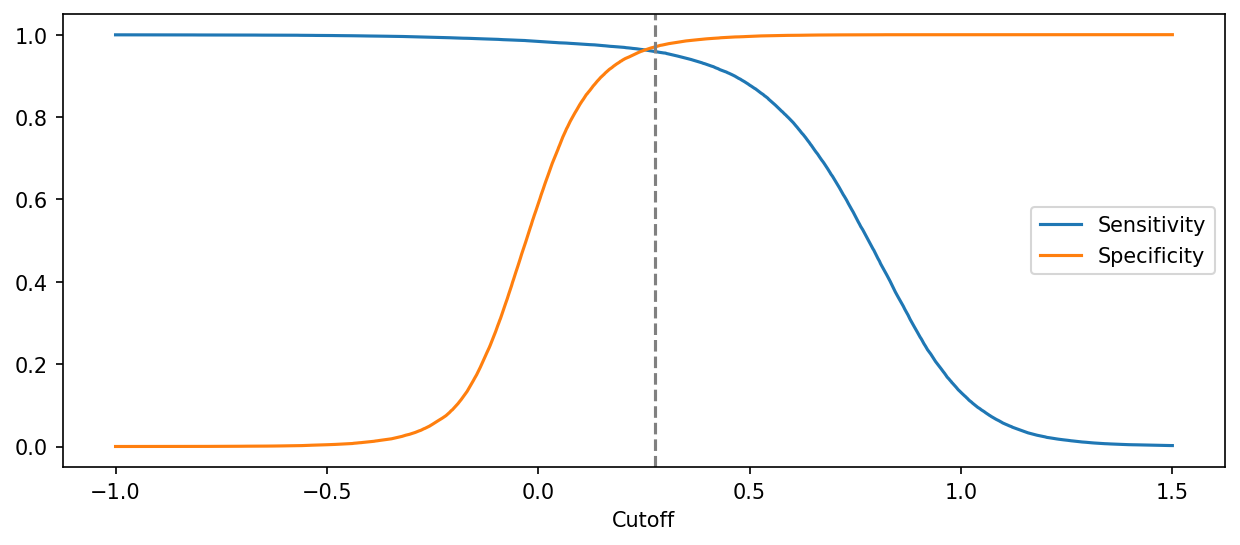

In [168]:
plt.figure(figsize=(10,4))
plt.plot(xcut, posfrac[posControl[amplicon]], label='Sensitivity')
         #posfrac[posControl[amplicon]] / (posfrac[posControl[amplicon]] + posfrac[negControl[amplicon]]), label='Sensitivity')
plt.plot(xcut, (1 - posfrac[negControl[amplicon]]), label='Specificity')# / ((1 - posfrac[posControl[amplicon]]) + (1 - posfrac[negControl[amplicon]])), label='Specificity')
plt.legend()
plt.xlabel('Cutoff')
plt.axvline(x=cutoff, color='gray', ls='--')

In [136]:
refseq[0:10]

Seq('ATCAGATTGA')

In [179]:
cutInfd = {'basei':[], 'eTLcut':[], 'eTLmax':[], 'eLIcut':[], 'eLImax':[]}

for b in tqdm(range(500), position=0):
    
    xcut = np.linspace(-1, 1.5, 2000)

    posfrac = {}

    for samp in [posControl[amplicon],negControl[amplicon]]:
        x = np.full(len(xcut), -1, 'float64')
        for i in range(len(xcut)):
            x[i] = (np.nansum(residuals[samp][:,b] > xcut[i]) + 1) / (np.sum(~np.isnan(residuals[samp][:,b])) + 1)
        posfrac[samp] = x

    yeslike = np.full(len(xcut), 0, 'float64')
    notlike = np.full(len(xcut), 0, 'float64')

    for x in range(len(xcut)):
        yeslike[x] = np.log10(posfrac[posControl[amplicon]][x]) - np.log10(posfrac[negControl[amplicon]][x])
        notlike[x] = np.log10(1 - posfrac[posControl[amplicon]][x]) - np.log10(1 - posfrac[negControl[amplicon]][x])

    expectedTrueLike = posfrac[posControl[amplicon]] * np.abs(yeslike) + (1-posfrac[negControl[amplicon]])*np.abs(notlike)

    
    expectedLikeInfo = (posfrac[posControl[amplicon]] * np.abs(yeslike) + 
                        (1-posfrac[negControl[amplicon]])*np.abs(notlike) - 
                        ((1 - posfrac[posControl[amplicon]]) * np.abs(notlike)) -
                        ((posfrac[negControl[amplicon]])*np.abs(yeslike)) )
    
    eTLim = np.argmax(expectedTrueLike)
    eLIim = np.argmax(expectedLikeInfo)
    
    cutInfd['basei'].append(b)
    cutInfd['eTLcut'].append(xcut[eTLim])
    cutInfd['eTLmax'].append(expectedTrueLike[eTLim])
    cutInfd['eLIcut'].append(xcut[eLIim])
    cutInfd['eLImax'].append(expectedLikeInfo[eLIim])
cutInf = pd.DataFrame(cutInfd)

  4%|▍         | 22/500 [00:21<07:36,  1.05it/s]<ipython-input-179-82d005c9281f>:20: RuntimeWarning: divide by zero encountered in log10
  notlike[x] = np.log10(1 - posfrac[posControl[amplicon]][x]) - np.log10(1 - posfrac[negControl[amplicon]][x])
<ipython-input-179-82d005c9281f>:22: RuntimeWarning: invalid value encountered in multiply
  expectedTrueLike = posfrac[posControl[amplicon]] * np.abs(yeslike) + (1-posfrac[negControl[amplicon]])*np.abs(notlike)
<ipython-input-179-82d005c9281f>:26: RuntimeWarning: invalid value encountered in multiply
  (1-posfrac[negControl[amplicon]])*np.abs(notlike) -
100%|██████████| 500/500 [07:36<00:00,  1.10it/s]


Text(0, 0.5, 'Max value')

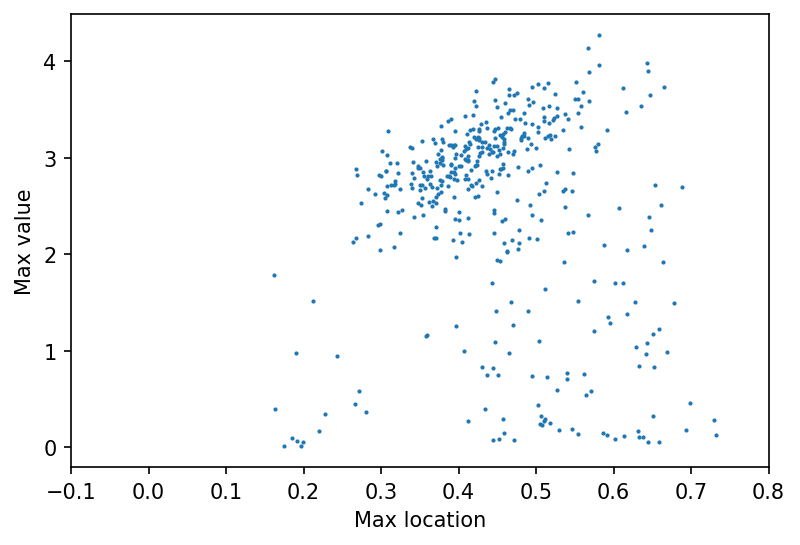

In [183]:
#plt.plot(cutInf['eTLcut'], cutInf['eTLmax'], '.')

plt.figure()
plt.plot(cutInf['eLIcut'], cutInf['eLImax'], '.', ms=2)
plt.xlim([-.1, .8])
plt.xlabel('Max location')
plt.ylabel('Max value')

#plt.figure(figsize=(4,4))
#plt.hist(cutInf['eLImax'], 40)
#plt.xlabel('max')

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(xcut, yeslike)
plt.plot(xcut, notlike)

In [59]:
minmol = min(residuals[0].shape[0], residuals[1].shape[0])
usemol0 = np.random.choice(np.arange(residuals[0].shape[0]), size=minmol, replace=False)
usemol1 = np.random.choice(np.arange(residuals[1].shape[0]), size=minmol, replace=False)
concdat = np.concatenate([residuals[0][usemol0,:], residuals[1][usemol1,:]])

smmfd = {'basei':[], 'threshold':[], 'meanlow':[], 'meanhigh':[], 'weighthigh':[], 'lowcut':[],
         'lowprob':[], 'aicd':[], 'cutoff':[]}

smmFitd = {}

for b in tqdm(range(residuals[0].shape[1]), position=0, smoothing=0):
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        smm1 = smm.SMM(1, tol=1e-6)
        smm1.fit(usedat)
        smm2 = smm.SMM(2, tol=1e-6, n_iter=1000)
        smm2.fit(usedat)
    smmFitd[b] = smm2
    
    xfine = np.linspace(0,1,1001)
    preda = smm2.predict_proba(xfine.reshape(-1,1))
    cutoff = xfine[np.abs(preda[:,1] - 0.5).argmin()]
    lowcut = preda[0,1]
    
    lowcomp = smm2.means_.flatten().argmin()
    highcomp = 1 - lowcomp
    
    smmfd['basei'].append(b)
    smmfd['threshold'].append(cutoff)
    smmfd['meanlow'].append(smm2.means_[lowcomp][0])
    smmfd['meanhigh'].append(smm2.means_[highcomp][0])
    smmfd['weighthigh'].append(smm2.weights_[highcomp])
    smmfd['lowcut'].append(lowcut)
    smmfd['lowprob'].append(smm2.predict_proba(np.array([-0.4]).reshape(-1,1))[0,highcomp])
    smmfd['aicd'].append(smm1.aic(usedat) - smm2.aic(usedat))
    smmfd['cutoff'].append(cutoff)
    
smmfd = pd.DataFrame(smmfd)

  0%|          | 0/1679 [00:00<?, ?it/s]


NameError: name 'warnings' is not defined

26.666666666666668

## HMM model for classifying accessibility
21/06/10

In [44]:
from pomegranate import HiddenMarkovModel, State, BernoulliDistribution


refs = {'indep':irefseq, 'dep':drefseq, 'widom':None}#wrefseq}
posControl = {'indep':0, 'dep':2, 'widom':45}
negControl = {'indep':1, 'dep':3, 'widom':44}
useSamples = {'indep':indepSamples, 'dep':depSamples, 'widom':[3, 44, 45, 47, 48, 51, 52]}

amplicon = 'indep'

refseq = refs[amplicon]
possamp = posControl[amplicon]
negsamp = negControl[amplicon]

bins = {}
for samp in useSamples[amplicon]:
    with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','binarized',
                               sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_binarized_SMM.npz')) as data:
        bins[samp] = data['methpred']

goodInd = np.sum(np.isnan(bins[negsamp]), axis=0) < bins[negsamp].shape[0]

refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T']}
abaseInd = np.nonzero(np.logical_or(refis['A'], refis['T']))[0]

goodBase = abaseInd[goodInd]

goodIndInd = np.nonzero(goodInd)[0]


# Find the probability of each good base being methylated in negative and positive controls  
posmprob = np.full((len(abaseInd)), np.nan)
for i in range(len(abaseInd)):
    if goodInd[i]:
        hasmeasure = ~np.isnan(bins[possamp][:,i])
        posmprob[i] = (np.sum(bins[possamp][hasmeasure,i] == 1) + .5) / (np.sum(hasmeasure) + .5)

negmprob = np.full((len(abaseInd)), np.nan)
for i in range(len(abaseInd)):
    if goodInd[i]:
        hasmeasure = ~np.isnan(bins[negsamp][:,i])
        negmprob[i] = (np.sum(bins[negsamp][hasmeasure,i] == 1) + .5) / (np.sum(hasmeasure) + .5)


In [45]:
AcAd = []
InacAd = []

for ib, b in enumerate(goodIndInd):
    AcAd.append(State(BernoulliDistribution(posmprob[b]), name="Ac_{0}".format(ib)))
    InacAd.append(State(BernoulliDistribution(negmprob[b]), name="Inac_{0}".format(ib)))
    
model = HiddenMarkovModel()
model.add_states(AcAd)
model.add_states(InacAd)
model.add_transition(model.start, AcAd[0], 0.5)
model.add_transition(model.start, InacAd[0], 0.5)

for b in np.arange(len(goodIndInd)-1):
    dist = abaseInd[goodIndInd[b+1]] - abaseInd[goodIndInd[b]]
    stayInacP = (1 - 1/1000)**dist
    model.add_transition(InacAd[b], InacAd[b+1], stayInacP)
    model.add_transition(InacAd[b], AcAd[b+1], 1 - stayInacP)
    stayAcP = (1 - 1/1000)**dist
    model.add_transition(AcAd[b], AcAd[b+1], stayAcP)
    model.add_transition(AcAd[b], InacAd[b+1], 1 - stayAcP)
    
model.add_transition(AcAd[len(goodIndInd)-1], model.end, 1)
model.add_transition(InacAd[len(goodIndInd)-1], model.end, 1)
model.bake()

In [46]:
useSamples = {'indep':redoInd, 'dep':redoDep}
for samp in useSamples[amplicon]:

    with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','binarized',
                               sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_binarized_SMM.npz')) as data:
        bins[samp] = data['methpred']
        
    refbases = np.arange(len(refseq))
    hmmRes = np.full((bins[samp].shape[0], len(refseq)), np.nan)
    for im in tqdm(np.arange(bins[samp].shape[0]), position=0, smoothing=0.001, mininterval=20,
                   desc=sampleRef['sampleName'][samp]):

        path = model.viterbi(bins[samp][im,goodInd])

        pathRes = np.full(len(goodIndInd), np.nan)
        for p in path[1]:
            psplit = p[1].name.split('_')
            if len(psplit) > 1:
                if psplit[0] == 'Ac':
                    pathRes[int(psplit[1])] = 1
                if psplit[0] == 'Inac':
                    pathRes[int(psplit[1])] = 0

        hmmRes[im,:] = np.interp(refbases, goodBase, pathRes)
        
    if not os.path.exists(dataPBase + '%s/processed/binarized' % (sampleRef['cell'][samp])):
        os.makedirs(dataPBase + '%s/processed/binarized' % (sampleRef['cell'][samp]))
        
    np.save(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','binarized',
                         sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_HMM.npy'),
            arr = hmmRes)

CTCF_Ind_5to1_plusADP_MT_rep2: 100%|██████████| 35135/35135 [1:35:22<00:00,  6.14it/s]


In [37]:
sampleRef.iloc[useSamples[amplicon]]

Unnamed: 0  index         cell                sampleName  \
3            3      3  pbrun4_gold           nuc47_chromatin   
44          44     44       pbrun6      47bp_DNA_minusM_rep1   
45          45     45       pbrun6       47bp_DNA_plusM_rep1   
47          47     47       pbrun6    RSC_47bp_minusATP_rep1   
48          48     48       pbrun6     RSC_47bp_plusATP_rep1   
51          51     51       pbrun6  Snf2h_47bp_minusATP_rep2   
52          52     52       pbrun6   Snf2h_47bp_plusATP_rep2   

                                unalignedSubreadsFile  \
3                                                 NaN   
44  /avicenna/vramani/analyses/pacbio/pbrun6/pbrun...   
45  /avicenna/vramani/analyses/pacbio/pbrun6/pbrun...   
47  /avicenna/vramani/analyses/pacbio/pbrun6/pbrun...   
48  /avicenna/vramani/analyses/pacbio/pbrun6/pbrun...   
51  /avicenna/vramani/analyses/pacbio/pbrun6/pbrun...   
52  /avicenna/vramani/analyses/pacbio/pbrun6/pbrun...   

                                              ccsFile  \
3   /avicenna/cmcnally/pbanalysis/data/PBRun_Gold....   
44  /avicenna/vramani/analyses/pacbio/pbrun6/ccs/p...   
45  /avicenna/vramani/analyses/pacbio/pbrun6/ccs/p...   
47  /avicenna/vramani/analyses/pacbio/pbrun6/ccs/p...   
48  /avicenna/vramani/analyses/pacbio/pbrun6/ccs/p...   
51  /avicenna/vramani/analyses/pacbio/pbrun6/ccs/p...   
52  /avicenna/vramani/analyses/pacbio/pbrun6/ccs/p...   

                                  alignedSubreadsFile  \
3   /avicenna/cmcnally/pbanalysis/data/PBRun_Gold....   
44  /avicenna/vramani/analyses/pacbio/pbrun6/align...   
45  /avicenna/vramani/analyses/pacbio/pbrun6/align...   
47  /avicenna/vramani/analyses/pacbio/pbrun6/align...   
48  /avicenna/vramani/analyses/pacbio/pbrun6/align...   
51  /avicenna/vramani/analyses/pacbio/pbrun6/align...   
52  /avicenna/vramani/analyses/pacbio/pbrun6/align...   

                                       alignedCcsFile  \
3                                                 NaN   
44  /avicenna/vramani/analyses/pacbio/pbrun6/ccs/p...   
45  /avicenna/vramani/analyses/pacbio/pbrun6/ccs/p...   
47  /avicenna/vramani/analyses/pacbio/pbrun6/ccs/p...   
48  /avicenna/vramani/analyses/pacbio/pbrun6/ccs/p...   
51  /avicenna/vramani/analyses/pacbio/pbrun6/ccs/p...   
52  /avicenna/vramani/analyses/pacbio/pbrun6/ccs/p...   

                                            reference processed  
3   /avicenna/vramani/analyses/pacbio/pbrun3/47nt_...       NaN  
44  /avicenna/vramani/analyses/pacbio/pbrun3/47nt_...       NaN  
45  /avicenna/vramani/analyses/pacbio/pbrun3/47nt_...       NaN  
47  /avicenna/vramani/analyses/pacbio/pbrun3/47nt_...       NaN  
48  /avicenna/vramani/analyses/pacbio/pbrun3/47nt_...       NaN  
51  /avicenna/vramani/analyses/pacbio/pbrun3/47nt_...       NaN  
52  /avicenna/vramani/analyses/pacbio/pbrun3/47nt_...       NaN

In [104]:
path = model.viterbi(bins[13][771,goodInd])

In [113]:
bins[samp].shape

(46908, 1679)

  3%|▎         | 1570/49183 [04:14<2:08:23,  6.18it/s]


KeyboardInterrupt: 

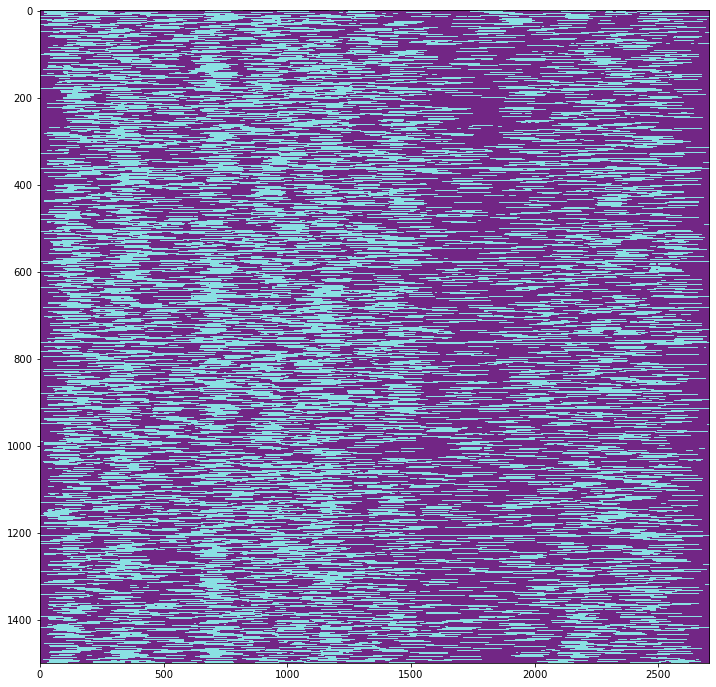

In [127]:
cmapbin = matplotlib.colors.LinearSegmentedColormap.from_list('custom cmap', ['#8ae0e3','#722685'], 3) #['midnightblue', 'coral']
bounds = np.array([-0.5, .5, 1.5])
norm = matplotlib.colors.BoundaryNorm(bounds, cmapbin.N)

plt.figure(figsize=(12,12))
plt.imshow(hmmRes[0:1500,:], aspect='auto', interpolation='none',cmap = cmapbin, norm=norm)

(-1.0, 2.0)

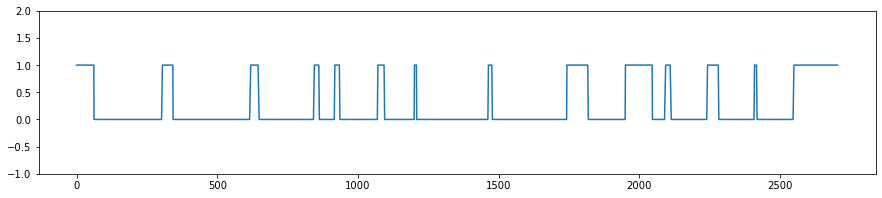

In [106]:
plt.figure(figsize=(15,3))
plt.plot(goodBase, pathRes)
plt.ylim([-1,2])

In [132]:
lprobhmm = model.forward(bins[samp][im,goodInd])

In [135]:
lprobhmm

array([[        -inf,         -inf,         -inf, ...,         -inf,
          0.        ,         -inf],
       [ -3.24528328,         -inf,         -inf, ...,         -inf,
                -inf,         -inf],
       [        -inf,  -4.70152677,         -inf, ...,         -inf,
                -inf,         -inf],
       ...,
       [        -inf,         -inf,         -inf, ...,         -inf,
                -inf,         -inf],
       [        -inf,         -inf,         -inf, ...,         -inf,
                -inf,         -inf],
       [        -inf,         -inf,         -inf, ...,         -inf,
                -inf, -61.6248339 ]])

In [112]:
a = np.interp(, goodBase, pathRes)
a[1000:1200]

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [24]:
# transition probability 
from scipy.stats import geom


geom.pmf(3, 1/147)


(1 - 1/40)**3

0.9268593749999999

In [36]:
np.nonzero(np.sum(np.isnan(bins[14]), axis=1) == 0)[0]

array([], dtype=int64)

In [42]:
State(BernoulliDistribution(.5), name="noome")

{
    "class" : "State",
    "distribution" : {
        "class" : "Distribution",
        "name" : "BernoulliDistribution",
        "parameters" : [
            0.5
        ],
        "frozen" : false
    },
    "name" : "noome",
    "weight" : 1.0
}

### Quick unrelated test of genomic singleA hmm issue
21/06/27

In [23]:
sampleRef = pd.read_csv(dataPBase + 'sampleRef_K562_mESC.csv', sep=',')

samp = 18
partN = -1
pieceN = 55

if partN < 0:
    inFileBase = '{0}/processed/forHMM/{0}_{1}_forHMM_piece{2:04d}.pickle'
    outFileBase = '{0}/processed/binarized/HMMout/{0}_{1}_HMMres_piece{2:04d}.pickle'
else:
    inFileBase = '{0}/processed/forHMM/{0}_{1}_forHMM_part' + str(partN) + '_piece{2:04d}.pickle'
    outFileBase = '{0}/processed/binarized/HMMout/{0}_{1}_HMMres_part' + str(partN) + '_piece{2:04d}.pickle'
with open(dataPBase + inFileBase.format(sampleRef['cell'][samp],
                                        sampleRef['sampleName'][samp],
                                        pieceN), 'rb') as fin:
    hmmInput = pickle.load(fin)
dlens = []
for key in hmmInput.keys():
    dlens.append(hmmInput[key]['inDat'].shape[0])
dlens = np.array(dlens)
dlens.sort()
dlens

In [30]:
from glob import glob

with open('/data/users/goodarzilab/colin/code/scripts/doHMM_p2.sh', 'w') as fout:
    for samp in [24,25,26,27]:
        pieces = glob(os.path.join(dataPBase,sampleRef['cell'][samp],'processed','forHMM',
                              sampleRef['cell'][samp] + '_' + 
                              sampleRef['sampleName'][samp] + '_forHMM_piece*.pickle'))
        ipiece = 0
        for p in pieces:
            fout.write('qsub /wynton/home/goodarzi/cpmcnally/code/scripts/shellRunAccessibilityHMM.sh {0} -1 {1}\n'.format(samp,
                                                                                                                        ipiece))
            ipiece += 1

In [ ]:
from glob import glob

with open('/data/users/goodarzilab/colin/code/scripts/doHMM_p4.sh', 'w') as fout:
    for samp in [20,21,22,23]:
        pieces = glob(os.path.join(dataPBase,sampleRef['cell'][samp],'processed','forHMM',
                              sampleRef['cell'][samp] + '_' + 
                              sampleRef['sampleName'][samp] + '_forHMM_piece*.pickle'))
        ipiece = 0
        for p in pieces:
            fout.write('qsub /wynton/home/goodarzi/cpmcnally/code/scripts/shellRunAccessibilityHMM.sh {0} {1}\n'.format(samp,
                                                                                                                        ipiece))
            ipiece += 1


In [ ]:
# compile the individual HMM result pieces
import numpy as np
import pandas as pd
import pickle
import os
from glob import glob
from tqdm import tqdm

dataPBase = '/wynton/group/goodarzilab/ramanilab/results/pacbio/'
sampleRef = pd.read_csv(dataPBase + 'sampleRef_K562_mESC.csv', sep=',')

samp = int(sys.argv)
parts = glob(os.path.join(dataPBase,sampleRef['cell'][samp],'processed','binarized','HMMout',sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_HMMres_piece*.pickle'))

HMMresults = {}

for part in parts:
    with open(part, 'rb') as fin:
        HMMpart = pickle.load(fin)
    for key in HMMpart.keys():
        HMMresults[key] = HMMpart[key].astype(np.float32)
        
with open(os.path.join(dataPBase,sampleRef['cell'][samp],'processed','binarized',sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsingle_HMM.pickle'), 'wb') as fout:
    pickle.dump(HMMresults, fout, protocol=4)
    

In [1]:
# temp code to do something from NN_SingleA

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from tqdm import tqdm
import pickle
import os
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf
import socket
from scipy.stats import norm


if 'biochem1' in socket.gethostname():
    dataPBase = '/avicenna/vramani/analyses/pacbio/'
    figPBase = '/avicenna/cmcnally/pbanalysis/'
if 'titan' in socket.gethostname():
    dataPBase = '/data/users/goodarzilab/colin/results/pacbio/'
if 'wynton' in socket.gethostname():
    dataPBase = '/wynton/group/goodarzilab/ramanilab/results/pacbio/'
if 'rumi' in socket.gethostname():
    raise Exception('no pacbio results folder on rumi')
    
sampleRef = pd.read_csv(dataPBase + 'sampleRef_K562_mESC.csv', sep=',', index_col=0)

# split up full files for SAMv2
import os

usesamples = [45,46,48]

zmwPerBlock = 50000

for samp in usesamples:
    with open(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','full',
                           sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_full.pickle'), 'rb') as fin:
        ipdfull = pickle.load(fin, encoding="latin1")
        
    zmws = sorted(list(ipdfull.keys()))
    
    nBlock = int(np.ceil(len(zmws) / zmwPerBlock))
    
    for block in tqdm(np.arange(1,nBlock+1), position=0, desc=sampleRef['sampleName'][samp]):
        ipdsub = {}
        bstart = (block-1) * zmwPerBlock
        bend = min(block * zmwPerBlock, len(zmws))
        for zmw in zmws[bstart:bend]:
            ipdsub[zmw] = ipdfull[zmw]
        outfile = os.path.join(dataPBase, sampleRef['cell'][samp],'processed','full',
                               sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_full_block{:03d}.pickle'.format(block))
        with open(outfile, 'wb') as fout:
            pickle.dump(ipdsub, fout, pickle.HIGHEST_PROTOCOL)

SNF2hKO_plusM_A7: 100%|██████████| 4/4 [00:25<00:00,  6.32s/it]


In [2]:
# check how many block files there are for each sample
import glob

usesamples = [45,46,48]
nblock = {}
for samp in usesamples:
    gl = glob.glob(dataPBase + '{0}/processed/full/{0}_{1}_full_block*.pickle'.format(sampleRef['cell'][samp],
                                                                                      sampleRef['sampleName'][samp]))
    nblock[samp] = len(gl)
    
sampL = []
blockL = []

for samp in usesamples:
    for block in np.arange(1,nblock[samp]+1):
        sampL.append(samp)
        blockL.append(block)

In [3]:
if not os.path.exists('/data/users/goodarzilab/colin/quickScripts'):
    os.makedirs('/data/users/goodarzilab/colin/quickScripts')
    
    
nScripts = 3
perS = int(np.ceil(len(blockL)/nScripts))

ix = 0

for scriptN in range(nScripts):
    with open('/data/users/goodarzilab/colin/quickScripts/makeNNinput_p{0}.sh'.format(scriptN), 'w') as fout:
        fout.write('#!/usr/bin/zsh\n\n')
        #fout.write('source /data/users/goodarzilab/colin/bin/miniconda3/etc/profile.d/conda.sh\n')
        fout.write('source /data/users/goodarzilab/colin/.zshrc\n\n')
        fout.write('conda activate NN2\n\n')
        for ix in np.arange(scriptN*perS, min((scriptN+1)*perS, len(sampL))):
            fout.write('python ~/code/scripts/formatNNinput.py {0} {1}\n'.format(sampL[ix], blockL[ix]))